In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "MIKC_MADS"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
#_, dataset = train_test_split(dataset_, test_size=0.02, stratify=dataset_['class'], random_state=42)
dataset = dataset_
dataset.head()

,id,sequence,length,class
0,Achn049281,MARGKIQIKRIENSTNRQVTYSKRRNGLFKKANELTVLCDAKVSII...,155,1
1,Achn112721,MGRGKIEIKKIENANNRQVTFSKRRGGLVKKAKELAILCDAEVALI...,175,1
2,Achn135681,MGRGKIEIKRIENPINRQVTYSKRRNGIFKKAQELTVLCDAKVSII...,213,1
3,Achn143731,MGRGRVQLKRIENKINRQVTFSKRRGGLLKKANEISVLCDAEVALI...,155,1
4,Achn147701,MGRGKIVIRRIDNTTSRQVTFSKRRTGLLKKAKELEILCDAEVGLV...,220,1


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
44,0.007812,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007812,0.000000,0.000000,...,0.000000,0.000000,0.007812,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
12341,0.002667,0.000000,0.010667,0.008000,0.000000,0.002667,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.002667,0.000000,0.000000,0.002667,0.0,0.008000,0.0,0.0,0.000000
4163,0.012605,0.000000,0.000000,0.004202,0.000000,0.004202,0.004202,0.000000,0.004202,0.008403,...,0.000000,0.004202,0.012605,0.000000,0.000000,0.0,0.004202,0.0,0.0,0.000000
8862,0.018868,0.000000,0.003774,0.007547,0.000000,0.003774,0.000000,0.000000,0.003774,0.015094,...,0.015094,0.000000,0.000000,0.007547,0.011321,0.0,0.000000,0.0,0.0,0.018868
7893,0.001661,0.003322,0.000000,0.000000,0.006645,0.006645,0.000000,0.003322,0.003322,0.001661,...,0.001661,0.006645,0.001661,0.000000,0.008306,0.0,0.000000,0.0,0.0,0.003322


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (11047, 441)
X_test: (2762, 441)
y_train: (11047,)
y_test: (2762,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1:27 634ms/step - accuracy: 0.5469 - loss: 0.6929

 25/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6729 - loss: 0.6778    

 50/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7512 - loss: 0.6138

 78/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8004 - loss: 0.5289

103/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8285 - loss: 0.4696

126/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8471 - loss: 0.4274

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8562 - loss: 0.4059 - val_accuracy: 0.9828 - val_loss: 0.0576


Epoch 2/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9844 - loss: 0.0452

 24/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9848 - loss: 0.0480 

 47/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9861 - loss: 0.0439

 70/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9869 - loss: 0.0427

 93/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9872 - loss: 0.0429

117/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9873 - loss: 0.0434

138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9875 - loss: 0.0437

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9875 - loss: 0.0437 - val_accuracy: 0.9873 - val_loss: 0.0474


Epoch 3/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 0.0093

 24/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9907 - loss: 0.0375 

 49/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9907 - loss: 0.0371

 74/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9907 - loss: 0.0377

 98/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9909 - loss: 0.0376

121/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9908 - loss: 0.0379

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9908 - loss: 0.0379 - val_accuracy: 0.9896 - val_loss: 0.0434


Epoch 4/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0033

 24/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9837 - loss: 0.0430 

 46/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9849 - loss: 0.0425

 69/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9865 - loss: 0.0397

 93/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9876 - loss: 0.0374

116/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9884 - loss: 0.0361

138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9889 - loss: 0.0352

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9889 - loss: 0.0351 - val_accuracy: 0.9810 - val_loss: 0.0684


Epoch 5/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9688 - loss: 0.0838

 25/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9881 - loss: 0.0467 

 49/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9900 - loss: 0.0382

 73/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9910 - loss: 0.0341

 98/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9916 - loss: 0.0315

121/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9918 - loss: 0.0302

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9919 - loss: 0.0294 - val_accuracy: 0.9900 - val_loss: 0.0305


Epoch 6/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0032

 24/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0055 

 47/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0086

 68/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0099

 90/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0109

113/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0116

137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.0124

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.0125 - val_accuracy: 0.9905 - val_loss: 0.0338


Epoch 7/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 6.9682e-04

 24/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9858 - loss: 0.0338     

 47/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9879 - loss: 0.0299

 69/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9892 - loss: 0.0269

 92/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9901 - loss: 0.0252

114/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9906 - loss: 0.0242

138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9911 - loss: 0.0233

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9912 - loss: 0.0233 - val_accuracy: 0.9914 - val_loss: 0.0301


Epoch 8/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0075

 25/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0136 

 49/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9953 - loss: 0.0133

 73/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0131

 96/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0127

119/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0122

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0122 - val_accuracy: 0.9914 - val_loss: 0.0309


Epoch 9/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0034

 24/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0114 

 47/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0102

 69/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0092

 91/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0086

113/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0088

138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0089

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9973 - loss: 0.0089 - val_accuracy: 0.9923 - val_loss: 0.0274


Epoch 10/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0062

 23/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0034 

 46/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0036

 69/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0041

 94/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0045

118/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0047

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0048 - val_accuracy: 0.9910 - val_loss: 0.0319


Epoch 11/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9844 - loss: 0.0131

 24/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0079 

 47/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.0071

 69/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0065

 93/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0063

116/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0062

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0062

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0062 - val_accuracy: 0.9882 - val_loss: 0.0512


Epoch 12/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 6.5713e-04

 23/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9935 - loss: 0.0143     

 47/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0121

 71/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9957 - loss: 0.0103

 95/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9963 - loss: 0.0091

118/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0084

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0080 - val_accuracy: 0.9910 - val_loss: 0.0389


Epoch 13/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 2.4995e-04

 25/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0025     

 49/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0037

 72/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0043

 97/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0049

121/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0052

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0055 - val_accuracy: 0.9878 - val_loss: 0.0461


Epoch 14/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 9.9437e-04

 25/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0051     

 49/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0048

 72/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0044

 95/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0040

120/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0037

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0036 - val_accuracy: 0.9887 - val_loss: 0.0474


Epoch 15/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 3.1708e-04

 26/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0040     

 50/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0048

 74/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0045

 97/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0043

121/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0043

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0043 - val_accuracy: 0.9864 - val_loss: 0.0685


Epoch 16/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 5.6747e-04

 24/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9949 - loss: 0.0119     

 47/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9946 - loss: 0.0128

 71/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0121

 96/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0113

119/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9955 - loss: 0.0108

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9957 - loss: 0.0103 - val_accuracy: 0.9923 - val_loss: 0.0346


Epoch 17/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0010

 26/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0046 

 48/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0046

 70/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0045

 93/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0047

114/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0049

136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0050

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9973 - loss: 0.0050 - val_accuracy: 0.9914 - val_loss: 0.0448


Epoch 18/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0029

 23/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0065 

 45/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0048

 67/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0040

 89/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0035

112/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0033

136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0035

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9986 - loss: 0.0035 - val_accuracy: 0.9914 - val_loss: 0.0562


Epoch 19/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0072

 24/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0104 

 46/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0077

 67/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0063

 90/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0054

112/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0049

136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0045

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0045 - val_accuracy: 0.9914 - val_loss: 0.0397



[Train Accuracy: 99.95% - Test Accuracy: 98.88%]


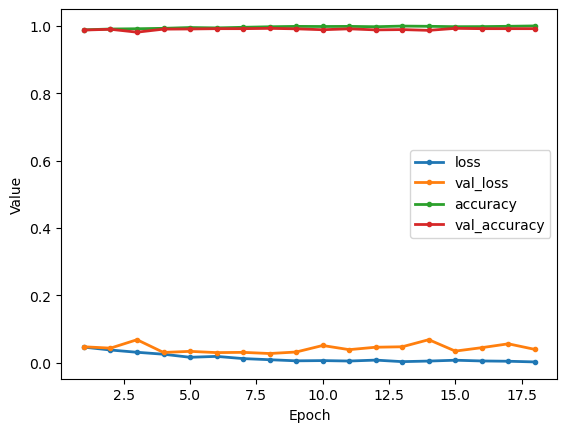

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/87 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step


 1/87 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
44,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
12341,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
4163,0.004219,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
8862,0.003788,0.0,0.0,0.003788,0.0,0.0,0.0,0.0,0.0,0.007576,...,0.007576,0.0,0.0,0.0,0.007576,0.0,0.0,0.0,0.0,0.003788
7893,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (11047, 8968)
X_test: (2762, 8968)
y_train: (11047,)
y_test: (2762,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,296,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,339,329 (8.92 MB)

 Trainable params: 2,339,329 (8.92 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1:56 846ms/step - accuracy: 0.5156 - loss: 0.6932

  8/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5301 - loss: 0.6927    

 15/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5931 - loss: 0.6911

 22/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6491 - loss: 0.6877

 29/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6885 - loss: 0.6815

 36/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7183 - loss: 0.6710

 43/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7420 - loss: 0.6558

 50/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7616 - loss: 0.6369

 57/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7781 - loss: 0.6157

 64/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7922 - loss: 0.5939

 71/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8044 - loss: 0.5726

 78/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8150 - loss: 0.5520

 85/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8244 - loss: 0.5328

 93/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8337 - loss: 0.5125

100/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8410 - loss: 0.4961

107/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8475 - loss: 0.4809

114/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8534 - loss: 0.4667

120/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8581 - loss: 0.4552

127/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8630 - loss: 0.4426

134/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8676 - loss: 0.4308

139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8713 - loss: 0.4212 - val_accuracy: 0.9928 - val_loss: 0.0260


Epoch 2/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 1.0000 - loss: 0.0050

  7/139 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0056 

 14/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9979 - loss: 0.0173

 21/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9974 - loss: 0.0206

 28/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9971 - loss: 0.0221

 35/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9966 - loss: 0.0237

 42/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9963 - loss: 0.0243

 49/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9962 - loss: 0.0244

 56/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9961 - loss: 0.0244

 62/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9961 - loss: 0.0241

 69/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9961 - loss: 0.0238

 76/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9961 - loss: 0.0236

 83/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9961 - loss: 0.0236

 90/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9960 - loss: 0.0239

 97/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9959 - loss: 0.0242

104/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9958 - loss: 0.0245

111/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9958 - loss: 0.0247

118/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9957 - loss: 0.0249

125/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9957 - loss: 0.0250

132/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9957 - loss: 0.0251

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9957 - loss: 0.0251 - val_accuracy: 0.9928 - val_loss: 0.0234


Epoch 3/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 1.0000 - loss: 0.0037

  7/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0049 

 14/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9981 - loss: 0.0139

 21/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9973 - loss: 0.0171

 28/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9971 - loss: 0.0179

 35/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9970 - loss: 0.0178

 42/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9970 - loss: 0.0177

 49/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9970 - loss: 0.0178

 56/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9970 - loss: 0.0176

 63/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9971 - loss: 0.0173

 70/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9971 - loss: 0.0171

 77/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9971 - loss: 0.0170

 84/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9971 - loss: 0.0170

 91/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9971 - loss: 0.0170

 98/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9970 - loss: 0.0170

105/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9970 - loss: 0.0170

112/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9970 - loss: 0.0170

119/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9970 - loss: 0.0169

126/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9970 - loss: 0.0169

133/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9970 - loss: 0.0169

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9970 - loss: 0.0169 - val_accuracy: 0.9946 - val_loss: 0.0173


Epoch 4/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 1.0000 - loss: 0.0027

  8/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0038 

 15/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9982 - loss: 0.0098

 22/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9966 - loss: 0.0146

 29/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9959 - loss: 0.0168

 36/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9956 - loss: 0.0179

 44/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9955 - loss: 0.0181

 51/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9956 - loss: 0.0179

 58/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9957 - loss: 0.0175

 65/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9958 - loss: 0.0172

 72/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9959 - loss: 0.0168

 79/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9960 - loss: 0.0165

 86/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9961 - loss: 0.0162

 93/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9961 - loss: 0.0159

100/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9962 - loss: 0.0157

108/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9962 - loss: 0.0155

115/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9962 - loss: 0.0153

122/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9962 - loss: 0.0152

129/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9963 - loss: 0.0150

136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9963 - loss: 0.0149

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9963 - loss: 0.0148 - val_accuracy: 0.9919 - val_loss: 0.0278


Epoch 5/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 1.0000 - loss: 9.9341e-04

  8/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9975 - loss: 0.0046     

 15/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9967 - loss: 0.0058

 22/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9966 - loss: 0.0059

 29/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9967 - loss: 0.0058

 36/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9969 - loss: 0.0056

 43/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9969 - loss: 0.0054

 50/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9970 - loss: 0.0053

 57/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9971 - loss: 0.0051

 64/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9971 - loss: 0.0050

 71/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9972 - loss: 0.0049

 78/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9972 - loss: 0.0048

 85/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9972 - loss: 0.0049

 92/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9971 - loss: 0.0049

 99/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9972 - loss: 0.0049

106/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9972 - loss: 0.0049

114/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9972 - loss: 0.0049

121/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9972 - loss: 0.0048

128/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9972 - loss: 0.0048

135/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9972 - loss: 0.0048

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9973 - loss: 0.0048 - val_accuracy: 0.9932 - val_loss: 0.0261


Epoch 6/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 1.0000 - loss: 3.9410e-04

  8/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 9.1243e-04 

 15/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0014    

 22/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0015

 29/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9999 - loss: 0.0016

 36/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9999 - loss: 0.0016

 43/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9998 - loss: 0.0016

 50/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9998 - loss: 0.0016

 57/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9998 - loss: 0.0016

 63/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0016

 70/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0017

 77/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0017

 84/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0016

 91/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0016

 98/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0016

105/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0016

112/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0016

119/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0016

126/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0016

133/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0016

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9997 - loss: 0.0016 - val_accuracy: 0.9955 - val_loss: 0.0170


Epoch 7/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 1.0000 - loss: 2.0114e-04

  8/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 2.8561e-04 

 15/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.7938e-04

 22/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.9848e-04

 29/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.9004e-04

 36/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.7764e-04

 43/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.7730e-04

 50/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9999 - loss: 5.5397e-04

 57/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9999 - loss: 6.6556e-04

 64/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9998 - loss: 7.4002e-04

 71/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9998 - loss: 7.8929e-04

 78/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9998 - loss: 8.2212e-04

 85/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9998 - loss: 8.4357e-04

 92/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9998 - loss: 8.5884e-04

 99/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 8.6807e-04

106/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 8.7274e-04

113/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 8.7381e-04

120/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 8.7213e-04

127/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 8.6827e-04

134/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 8.6294e-04

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9997 - loss: 8.5756e-04 - val_accuracy: 0.9941 - val_loss: 0.0135


Epoch 8/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 1.0000 - loss: 7.7264e-05

  8/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 6.7981e-05 

 15/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.5754e-05

 22/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.9348e-05

 29/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.9889e-05

 36/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.4447e-05

 43/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.8086e-05

 50/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.0883e-05

 57/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.3002e-05

 64/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.6947e-05

 71/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0012e-04

 79/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0548e-04

 86/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1257e-04

 93/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1813e-04

100/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2302e-04

107/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2740e-04

114/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3082e-04

121/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3345e-04

128/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3543e-04

135/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3705e-04

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.3803e-04 - val_accuracy: 0.9959 - val_loss: 0.0168


Epoch 9/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 1.0000 - loss: 1.4543e-05

  8/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 2.9454e-05 

 15/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.2274e-05

 22/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.5097e-05

 29/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.6001e-05

 36/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.5162e-05

 43/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.0180e-05

 50/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.3070e-05

 57/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.6007e-05

 65/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.9905e-05

 72/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.1956e-05

 79/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.6199e-05

 86/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.1397e-05

 93/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.5525e-05

100/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.9071e-05

107/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.1799e-05

114/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.3948e-05

121/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.5533e-05

128/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.9447e-05

135/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0332e-04

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.0605e-04 - val_accuracy: 0.9919 - val_loss: 0.0429


Epoch 10/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 1.0000 - loss: 0.0010

  8/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 9.9925e-04

 15/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.3049e-04

 22/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.8874e-04

 29/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.9899e-04

 36/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.3639e-04

 43/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.9402e-04

 50/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.6575e-04

 57/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.4504e-04

 64/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.2684e-04

 71/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.1099e-04

 78/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9729e-04

 85/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.8515e-04

 92/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.7609e-04

 99/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.7106e-04

106/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.6693e-04

113/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.6302e-04

120/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.5905e-04

127/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.5504e-04

134/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.5100e-04

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 2.4758e-04 - val_accuracy: 0.9950 - val_loss: 0.0161


Epoch 11/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 1.0000 - loss: 1.3242e-05

  8/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.0470e-05 

 15/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2323e-05

 22/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2941e-05

 29/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.5595e-05

 36/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.1136e-05

 43/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.0859e-05

 50/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.4956e-05

 57/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.4688e-05

 64/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.1297e-05

 71/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.6525e-05

 78/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.9967e-05

 85/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.2250e-05

 92/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.3741e-05

 99/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.4689e-05

106/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.0750e-05

113/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1207e-04

120/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3607e-04

127/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.5636e-04

134/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7449e-04

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.8817e-04 - val_accuracy: 0.9955 - val_loss: 0.0280


Epoch 12/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 1.0000 - loss: 7.4439e-05

  8/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.0868e-05 

 15/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.7467e-05

 22/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.5919e-05

 29/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.5084e-05

 36/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.4819e-05

 43/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.4083e-05

 50/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.3380e-05

 57/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.2707e-05

 64/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.2296e-05

 71/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.3959e-05

 78/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.9399e-05

 85/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.3578e-05

 92/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.6803e-05

 99/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.9318e-05

106/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.1312e-05

113/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.2870e-05

120/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.4180e-05

127/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1049e-04

134/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.7293e-04

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 2.1938e-04 - val_accuracy: 0.9946 - val_loss: 0.0247


Epoch 13/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 1.0000 - loss: 2.2228e-04

  8/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9966 - loss: 0.0175     

 16/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9977 - loss: 0.0125

 23/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9981 - loss: 0.0101

 30/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9984 - loss: 0.0087

 37/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9985 - loss: 0.0077

 44/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9986 - loss: 0.0070

 52/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9987 - loss: 0.0063

 59/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9988 - loss: 0.0058

 66/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9989 - loss: 0.0054

 73/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9990 - loss: 0.0051

 81/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9990 - loss: 0.0047

 89/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9991 - loss: 0.0044

 96/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9991 - loss: 0.0042

103/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9992 - loss: 0.0040

110/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9992 - loss: 0.0038

117/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9992 - loss: 0.0037

124/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9993 - loss: 0.0035

132/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9993 - loss: 0.0034

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9993 - loss: 0.0033

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9993 - loss: 0.0033 - val_accuracy: 0.9950 - val_loss: 0.0225


Epoch 14/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 1.0000 - loss: 7.3021e-06

  8/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0168e-05 

 15/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1230e-05

 22/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3021e-05

 29/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4492e-05

 36/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5483e-05

 43/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8482e-05

 50/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3335e-05

 57/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.6897e-05

 65/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9724e-05

 72/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.1497e-05

 79/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.2812e-05

 86/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.3898e-05

 93/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.4824e-05

100/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.5484e-05

107/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.5981e-05

114/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.6334e-05

121/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.6579e-05

128/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.6768e-05

135/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.6854e-05

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 3.6874e-05 - val_accuracy: 0.9955 - val_loss: 0.0196


Epoch 15/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 1.0000 - loss: 1.3542e-05

  8/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9529e-05 

 15/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.8613e-05

 22/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9840e-05

 29/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.0621e-05

 36/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.0968e-05

 43/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.0256e-05

 50/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9113e-05

 57/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.7949e-05

 64/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.6932e-05

 71/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.5945e-05

 78/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.5186e-05

 85/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.4435e-05

 92/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.3744e-05

 99/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.3250e-05

106/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.2988e-05

113/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.3601e-05

121/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.4100e-05

128/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.4406e-05

135/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.4621e-05

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 3.4728e-05 - val_accuracy: 0.9959 - val_loss: 0.0178


Epoch 16/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 1.0000 - loss: 7.8085e-06

  8/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.9008e-06 

 16/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0110e-05

 24/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1181e-05

 31/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1779e-05

 38/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2308e-05

 45/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2723e-05

 52/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3014e-05

 59/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3258e-05

 66/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3457e-05

 73/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3605e-05

 80/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3684e-05

 87/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3719e-05

 94/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3707e-05

101/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3769e-05

108/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3818e-05

115/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3861e-05

122/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3903e-05

129/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3938e-05

136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3986e-05

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.4007e-05 - val_accuracy: 0.9959 - val_loss: 0.0191


Epoch 17/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 1.0000 - loss: 1.0220e-05

  8/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.6876e-05 

 15/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.8772e-05

 22/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.7765e-05

 29/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.6759e-05

 35/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.6130e-05

 42/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.6493e-05

 49/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.6833e-05

 56/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.7874e-05

 63/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.8594e-05

 70/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.9073e-05

 77/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.9535e-05

 84/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.9802e-05

 91/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.9914e-05

 98/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.9929e-05

105/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.9879e-05

112/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.9773e-05

119/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.9639e-05

126/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.9486e-05

133/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.9338e-05

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.9185e-05 - val_accuracy: 0.9955 - val_loss: 0.0206


Epoch 18/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 1.0000 - loss: 1.5713e-05

  8/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3780e-05 

 15/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.1649e-05

 22/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.9416e-05

 29/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.7595e-05

 36/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.6222e-05

 43/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.5250e-05

 50/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4495e-05

 57/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3836e-05

 64/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3297e-05

 71/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2847e-05

 78/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2452e-05

 85/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2099e-05

 92/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1775e-05

 99/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1472e-05

106/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1205e-05

113/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0965e-05

120/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0746e-05

127/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0541e-05

134/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0372e-05

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.0235e-05 - val_accuracy: 0.9955 - val_loss: 0.0210



[Train Accuracy: 100.00% - Test Accuracy: 99.38%]


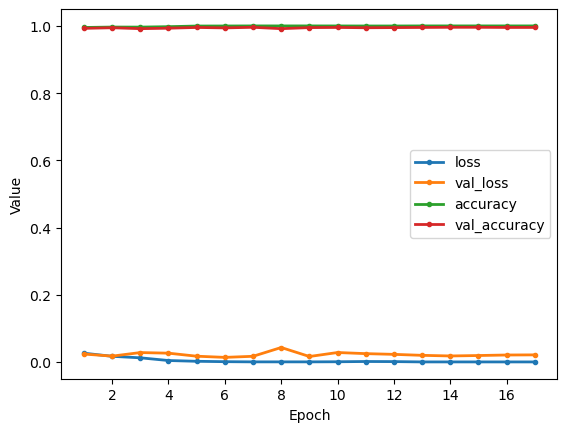

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/87 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step

42/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 1/87 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

43/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

85/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003802,...,0.0,0.003802,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      39,885,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,927,041 (152.31 MB)

 Trainable params: 39,927,041 (152.31 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 2:10 942ms/step - accuracy: 0.4844 - loss: 0.6932

  2/139 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 0.5117 - loss: 0.6930 

  3/139 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.5321 - loss: 0.6927

  4/139 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - accuracy: 0.5407 - loss: 0.6926

  5/139 ━━━━━━━━━━━━━━━━━━━━ 18s 138ms/step - accuracy: 0.5413 - loss: 0.6926

  6/139 ━━━━━━━━━━━━━━━━━━━━ 18s 140ms/step - accuracy: 0.5422 - loss: 0.6926

  7/139 ━━━━━━━━━━━━━━━━━━━━ 18s 140ms/step - accuracy: 0.5397 - loss: 0.6926

  8/139 ━━━━━━━━━━━━━━━━━━━━ 18s 139ms/step - accuracy: 0.5369 - loss: 0.6927

  9/139 ━━━━━━━━━━━━━━━━━━━━ 18s 139ms/step - accuracy: 0.5342 - loss: 0.6927

 10/139 ━━━━━━━━━━━━━━━━━━━━ 17s 139ms/step - accuracy: 0.5308 - loss: 0.6928

 11/139 ━━━━━━━━━━━━━━━━━━━━ 17s 140ms/step - accuracy: 0.5278 - loss: 0.6928

 12/139 ━━━━━━━━━━━━━━━━━━━━ 17s 140ms/step - accuracy: 0.5248 - loss: 0.6928

 13/139 ━━━━━━━━━━━━━━━━━━━━ 17s 140ms/step - accuracy: 0.5226 - loss: 0.6928

 14/139 ━━━━━━━━━━━━━━━━━━━━ 17s 140ms/step - accuracy: 0.5209 - loss: 0.6928

 15/139 ━━━━━━━━━━━━━━━━━━━━ 17s 140ms/step - accuracy: 0.5200 - loss: 0.6927

 16/139 ━━━━━━━━━━━━━━━━━━━━ 17s 141ms/step - accuracy: 0.5197 - loss: 0.6926

 17/139 ━━━━━━━━━━━━━━━━━━━━ 17s 142ms/step - accuracy: 0.5193 - loss: 0.6925

 18/139 ━━━━━━━━━━━━━━━━━━━━ 17s 142ms/step - accuracy: 0.5191 - loss: 0.6924

 19/139 ━━━━━━━━━━━━━━━━━━━━ 17s 142ms/step - accuracy: 0.5190 - loss: 0.6923

 20/139 ━━━━━━━━━━━━━━━━━━━━ 16s 142ms/step - accuracy: 0.5188 - loss: 0.6922

 21/139 ━━━━━━━━━━━━━━━━━━━━ 16s 142ms/step - accuracy: 0.5184 - loss: 0.6920

 22/139 ━━━━━━━━━━━━━━━━━━━━ 16s 142ms/step - accuracy: 0.5180 - loss: 0.6919

 23/139 ━━━━━━━━━━━━━━━━━━━━ 16s 142ms/step - accuracy: 0.5181 - loss: 0.6917

 24/139 ━━━━━━━━━━━━━━━━━━━━ 16s 142ms/step - accuracy: 0.5187 - loss: 0.6915

 25/139 ━━━━━━━━━━━━━━━━━━━━ 16s 143ms/step - accuracy: 0.5197 - loss: 0.6914

 26/139 ━━━━━━━━━━━━━━━━━━━━ 16s 142ms/step - accuracy: 0.5212 - loss: 0.6911

 27/139 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 0.5232 - loss: 0.6909

 28/139 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 0.5254 - loss: 0.6906

 29/139 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 0.5278 - loss: 0.6903

 30/139 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 0.5305 - loss: 0.6900

 31/139 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 0.5333 - loss: 0.6896

 32/139 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 0.5362 - loss: 0.6892

 33/139 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 0.5391 - loss: 0.6888

 34/139 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 0.5422 - loss: 0.6883

 35/139 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 0.5453 - loss: 0.6878

 36/139 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 0.5484 - loss: 0.6873

 37/139 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 0.5515 - loss: 0.6867

 38/139 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 0.5547 - loss: 0.6861

 39/139 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 0.5579 - loss: 0.6854

 40/139 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 0.5612 - loss: 0.6847

 41/139 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 0.5644 - loss: 0.6840

 42/139 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 0.5676 - loss: 0.6832

 43/139 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 0.5708 - loss: 0.6823

 44/139 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 0.5740 - loss: 0.6814

 45/139 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 0.5772 - loss: 0.6804

 46/139 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 0.5804 - loss: 0.6794

 47/139 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 0.5836 - loss: 0.6782

 48/139 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 0.5867 - loss: 0.6771

 49/139 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 0.5898 - loss: 0.6759

 50/139 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 0.5928 - loss: 0.6746

 51/139 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 0.5959 - loss: 0.6732

 52/139 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 0.5989 - loss: 0.6718

 53/139 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 0.6019 - loss: 0.6703

 54/139 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 0.6048 - loss: 0.6687

 55/139 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 0.6077 - loss: 0.6671

 56/139 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 0.6106 - loss: 0.6655

 57/139 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 0.6134 - loss: 0.6638

 58/139 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 0.6162 - loss: 0.6620

 59/139 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 0.6190 - loss: 0.6602

 60/139 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 0.6217 - loss: 0.6584

 61/139 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 0.6244 - loss: 0.6565

 62/139 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 0.6270 - loss: 0.6545

 63/139 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 0.6296 - loss: 0.6525

 64/139 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 0.6322 - loss: 0.6505

 65/139 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 0.6347 - loss: 0.6484

 66/139 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.6372 - loss: 0.6463

 67/139 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.6397 - loss: 0.6442

 68/139 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.6422 - loss: 0.6420

 69/139 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.6446 - loss: 0.6398

 70/139 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.6469 - loss: 0.6376

 71/139 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.6493 - loss: 0.6354

 72/139 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 0.6516 - loss: 0.6331

 73/139 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 0.6538 - loss: 0.6308 

 74/139 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 0.6561 - loss: 0.6285

 75/139 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 0.6583 - loss: 0.6262

 76/139 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 0.6605 - loss: 0.6239

 77/139 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 0.6626 - loss: 0.6216

 78/139 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 0.6648 - loss: 0.6192

 79/139 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 0.6669 - loss: 0.6169

 80/139 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 0.6689 - loss: 0.6146

 81/139 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 0.6710 - loss: 0.6122

 82/139 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 0.6730 - loss: 0.6099

 83/139 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 0.6750 - loss: 0.6075

 84/139 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 0.6770 - loss: 0.6052

 85/139 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 0.6789 - loss: 0.6029

 86/139 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.6808 - loss: 0.6006

 87/139 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.6827 - loss: 0.5983

 88/139 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.6846 - loss: 0.5960

 89/139 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.6864 - loss: 0.5937

 90/139 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.6882 - loss: 0.5915

 91/139 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.6900 - loss: 0.5892

 92/139 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.6918 - loss: 0.5869

 93/139 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.6935 - loss: 0.5847

 94/139 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.6952 - loss: 0.5825

 95/139 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.6969 - loss: 0.5802

 96/139 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.6986 - loss: 0.5780

 97/139 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.7003 - loss: 0.5758

 98/139 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.7019 - loss: 0.5736

 99/139 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.7035 - loss: 0.5714

100/139 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.7051 - loss: 0.5692

101/139 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.7067 - loss: 0.5670

102/139 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.7083 - loss: 0.5648

103/139 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.7098 - loss: 0.5627

104/139 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.7114 - loss: 0.5605

105/139 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.7129 - loss: 0.5584

106/139 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.7144 - loss: 0.5563

107/139 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.7159 - loss: 0.5542

108/139 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.7173 - loss: 0.5521

109/139 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.7188 - loss: 0.5501

110/139 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.7202 - loss: 0.5480

111/139 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.7216 - loss: 0.5460

112/139 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.7230 - loss: 0.5440

113/139 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.7244 - loss: 0.5420

114/139 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.7257 - loss: 0.5400

115/139 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.7271 - loss: 0.5380

116/139 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.7284 - loss: 0.5360

117/139 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.7297 - loss: 0.5341

118/139 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.7310 - loss: 0.5321

119/139 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.7323 - loss: 0.5302

120/139 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.7336 - loss: 0.5283

121/139 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.7348 - loss: 0.5264

122/139 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.7361 - loss: 0.5245

123/139 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.7373 - loss: 0.5226

124/139 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.7385 - loss: 0.5208

125/139 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.7397 - loss: 0.5189

126/139 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.7409 - loss: 0.5171

127/139 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.7421 - loss: 0.5153

128/139 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.7433 - loss: 0.5135

129/139 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.7444 - loss: 0.5117

130/139 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.7456 - loss: 0.5099

131/139 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.7467 - loss: 0.5081

132/139 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.7478 - loss: 0.5064

133/139 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.7489 - loss: 0.5046

134/139 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.7500 - loss: 0.5029

135/139 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.7511 - loss: 0.5012

136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.7522 - loss: 0.4995

137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.7533 - loss: 0.4978

138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.7543 - loss: 0.4961

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.7554 - loss: 0.4945

139/139 ━━━━━━━━━━━━━━━━━━━━ 28s 198ms/step - accuracy: 0.7564 - loss: 0.4929 - val_accuracy: 0.9919 - val_loss: 0.0324


Epoch 2/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 54s 393ms/step - accuracy: 1.0000 - loss: 0.0060

  2/139 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - accuracy: 0.9922 - loss: 0.0667

  3/139 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - accuracy: 0.9913 - loss: 0.0734

  4/139 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9915 - loss: 0.0718

  5/139 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - accuracy: 0.9920 - loss: 0.0684

  6/139 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - accuracy: 0.9924 - loss: 0.0648

  7/139 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - accuracy: 0.9929 - loss: 0.0614

  8/139 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - accuracy: 0.9933 - loss: 0.0583

  9/139 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - accuracy: 0.9936 - loss: 0.0555

 10/139 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - accuracy: 0.9940 - loss: 0.0531

 11/139 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - accuracy: 0.9943 - loss: 0.0509

 12/139 ━━━━━━━━━━━━━━━━━━━━ 20s 159ms/step - accuracy: 0.9945 - loss: 0.0489

 13/139 ━━━━━━━━━━━━━━━━━━━━ 20s 159ms/step - accuracy: 0.9947 - loss: 0.0478

 14/139 ━━━━━━━━━━━━━━━━━━━━ 20s 160ms/step - accuracy: 0.9948 - loss: 0.0466

 15/139 ━━━━━━━━━━━━━━━━━━━━ 19s 159ms/step - accuracy: 0.9949 - loss: 0.0456

 16/139 ━━━━━━━━━━━━━━━━━━━━ 19s 159ms/step - accuracy: 0.9951 - loss: 0.0445

 17/139 ━━━━━━━━━━━━━━━━━━━━ 19s 160ms/step - accuracy: 0.9952 - loss: 0.0435

 18/139 ━━━━━━━━━━━━━━━━━━━━ 19s 160ms/step - accuracy: 0.9953 - loss: 0.0426

 19/139 ━━━━━━━━━━━━━━━━━━━━ 19s 160ms/step - accuracy: 0.9954 - loss: 0.0416

 20/139 ━━━━━━━━━━━━━━━━━━━━ 19s 160ms/step - accuracy: 0.9956 - loss: 0.0408

 21/139 ━━━━━━━━━━━━━━━━━━━━ 18s 160ms/step - accuracy: 0.9957 - loss: 0.0399

 22/139 ━━━━━━━━━━━━━━━━━━━━ 18s 160ms/step - accuracy: 0.9957 - loss: 0.0394

 23/139 ━━━━━━━━━━━━━━━━━━━━ 18s 160ms/step - accuracy: 0.9958 - loss: 0.0388

 24/139 ━━━━━━━━━━━━━━━━━━━━ 18s 160ms/step - accuracy: 0.9959 - loss: 0.0382

 25/139 ━━━━━━━━━━━━━━━━━━━━ 18s 160ms/step - accuracy: 0.9959 - loss: 0.0377

 26/139 ━━━━━━━━━━━━━━━━━━━━ 18s 160ms/step - accuracy: 0.9960 - loss: 0.0371

 27/139 ━━━━━━━━━━━━━━━━━━━━ 17s 159ms/step - accuracy: 0.9961 - loss: 0.0366

 28/139 ━━━━━━━━━━━━━━━━━━━━ 17s 158ms/step - accuracy: 0.9961 - loss: 0.0361

 29/139 ━━━━━━━━━━━━━━━━━━━━ 17s 158ms/step - accuracy: 0.9962 - loss: 0.0357

 30/139 ━━━━━━━━━━━━━━━━━━━━ 17s 158ms/step - accuracy: 0.9962 - loss: 0.0352

 31/139 ━━━━━━━━━━━━━━━━━━━━ 17s 158ms/step - accuracy: 0.9963 - loss: 0.0347

 32/139 ━━━━━━━━━━━━━━━━━━━━ 16s 158ms/step - accuracy: 0.9963 - loss: 0.0343

 33/139 ━━━━━━━━━━━━━━━━━━━━ 16s 158ms/step - accuracy: 0.9964 - loss: 0.0339

 34/139 ━━━━━━━━━━━━━━━━━━━━ 16s 158ms/step - accuracy: 0.9965 - loss: 0.0334

 35/139 ━━━━━━━━━━━━━━━━━━━━ 16s 158ms/step - accuracy: 0.9965 - loss: 0.0330

 36/139 ━━━━━━━━━━━━━━━━━━━━ 16s 158ms/step - accuracy: 0.9965 - loss: 0.0326

 37/139 ━━━━━━━━━━━━━━━━━━━━ 16s 158ms/step - accuracy: 0.9966 - loss: 0.0323

 38/139 ━━━━━━━━━━━━━━━━━━━━ 15s 158ms/step - accuracy: 0.9966 - loss: 0.0319

 39/139 ━━━━━━━━━━━━━━━━━━━━ 15s 157ms/step - accuracy: 0.9967 - loss: 0.0316

 40/139 ━━━━━━━━━━━━━━━━━━━━ 15s 158ms/step - accuracy: 0.9967 - loss: 0.0313

 41/139 ━━━━━━━━━━━━━━━━━━━━ 15s 158ms/step - accuracy: 0.9967 - loss: 0.0310

 42/139 ━━━━━━━━━━━━━━━━━━━━ 15s 157ms/step - accuracy: 0.9968 - loss: 0.0307

 43/139 ━━━━━━━━━━━━━━━━━━━━ 15s 157ms/step - accuracy: 0.9968 - loss: 0.0303

 44/139 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.9968 - loss: 0.0300

 45/139 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.9969 - loss: 0.0298

 46/139 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.9969 - loss: 0.0295

 47/139 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - accuracy: 0.9969 - loss: 0.0292

 48/139 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - accuracy: 0.9969 - loss: 0.0289

 49/139 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - accuracy: 0.9970 - loss: 0.0287

 50/139 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - accuracy: 0.9970 - loss: 0.0284

 51/139 ━━━━━━━━━━━━━━━━━━━━ 13s 155ms/step - accuracy: 0.9970 - loss: 0.0281

 52/139 ━━━━━━━━━━━━━━━━━━━━ 13s 155ms/step - accuracy: 0.9971 - loss: 0.0279

 53/139 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - accuracy: 0.9971 - loss: 0.0277

 54/139 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - accuracy: 0.9971 - loss: 0.0274

 55/139 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - accuracy: 0.9971 - loss: 0.0272

 56/139 ━━━━━━━━━━━━━━━━━━━━ 12s 155ms/step - accuracy: 0.9971 - loss: 0.0271

 57/139 ━━━━━━━━━━━━━━━━━━━━ 12s 155ms/step - accuracy: 0.9971 - loss: 0.0269

 58/139 ━━━━━━━━━━━━━━━━━━━━ 12s 155ms/step - accuracy: 0.9971 - loss: 0.0267

 59/139 ━━━━━━━━━━━━━━━━━━━━ 12s 155ms/step - accuracy: 0.9972 - loss: 0.0265

 60/139 ━━━━━━━━━━━━━━━━━━━━ 12s 155ms/step - accuracy: 0.9972 - loss: 0.0263

 61/139 ━━━━━━━━━━━━━━━━━━━━ 12s 155ms/step - accuracy: 0.9972 - loss: 0.0262

 62/139 ━━━━━━━━━━━━━━━━━━━━ 11s 155ms/step - accuracy: 0.9972 - loss: 0.0260

 63/139 ━━━━━━━━━━━━━━━━━━━━ 11s 155ms/step - accuracy: 0.9972 - loss: 0.0259

 64/139 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step - accuracy: 0.9972 - loss: 0.0258

 65/139 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step - accuracy: 0.9972 - loss: 0.0256

 66/139 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step - accuracy: 0.9972 - loss: 0.0255

 67/139 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step - accuracy: 0.9972 - loss: 0.0255

 68/139 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.9972 - loss: 0.0254

 69/139 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.9972 - loss: 0.0253

 70/139 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.9972 - loss: 0.0252

 71/139 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.9972 - loss: 0.0251

 72/139 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.9972 - loss: 0.0251

 73/139 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.9972 - loss: 0.0250

 74/139 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - accuracy: 0.9972 - loss: 0.0249 

 75/139 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - accuracy: 0.9972 - loss: 0.0248

 76/139 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - accuracy: 0.9972 - loss: 0.0247

 77/139 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - accuracy: 0.9972 - loss: 0.0246

 78/139 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - accuracy: 0.9972 - loss: 0.0246

 79/139 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - accuracy: 0.9972 - loss: 0.0245

 80/139 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - accuracy: 0.9972 - loss: 0.0244

 81/139 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.9972 - loss: 0.0243

 82/139 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 0.9972 - loss: 0.0242

 83/139 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.9972 - loss: 0.0242

 84/139 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 0.9972 - loss: 0.0241

 85/139 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.9972 - loss: 0.0240

 86/139 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 0.9972 - loss: 0.0239

 87/139 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.9972 - loss: 0.0239

 88/139 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.9972 - loss: 0.0238

 89/139 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.9973 - loss: 0.0237

 90/139 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.9973 - loss: 0.0237

 91/139 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.9973 - loss: 0.0236

 92/139 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.9973 - loss: 0.0235

 93/139 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.9973 - loss: 0.0235

 94/139 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.9973 - loss: 0.0234

 95/139 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.9973 - loss: 0.0233

 96/139 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.9973 - loss: 0.0233

 97/139 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.9973 - loss: 0.0232

 98/139 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.9973 - loss: 0.0232

 99/139 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.9973 - loss: 0.0231

100/139 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.9973 - loss: 0.0230

101/139 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.9973 - loss: 0.0230

102/139 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.9973 - loss: 0.0229

103/139 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.9973 - loss: 0.0229

104/139 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.9973 - loss: 0.0229

105/139 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.9973 - loss: 0.0228

106/139 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.9973 - loss: 0.0228

107/139 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.9973 - loss: 0.0228

108/139 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.9973 - loss: 0.0228

109/139 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.9973 - loss: 0.0228

110/139 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.9972 - loss: 0.0228

111/139 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.9972 - loss: 0.0227

112/139 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.9972 - loss: 0.0227

113/139 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.9972 - loss: 0.0227

114/139 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.9972 - loss: 0.0227

115/139 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.9972 - loss: 0.0227

116/139 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.9972 - loss: 0.0227

117/139 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.9972 - loss: 0.0227

118/139 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.9972 - loss: 0.0226

119/139 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.9972 - loss: 0.0226

120/139 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.9972 - loss: 0.0226

121/139 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.9972 - loss: 0.0226

122/139 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.9972 - loss: 0.0226

123/139 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.9972 - loss: 0.0226

124/139 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.9972 - loss: 0.0226

125/139 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.9972 - loss: 0.0225

126/139 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.9972 - loss: 0.0225

127/139 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.9972 - loss: 0.0225

128/139 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.9972 - loss: 0.0225

129/139 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.9971 - loss: 0.0225

130/139 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.9971 - loss: 0.0225

131/139 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.9971 - loss: 0.0224

132/139 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.9971 - loss: 0.0224

133/139 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9971 - loss: 0.0224

134/139 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9971 - loss: 0.0224

135/139 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9971 - loss: 0.0224

136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9971 - loss: 0.0223

137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9971 - loss: 0.0223

138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9971 - loss: 0.0223

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9971 - loss: 0.0223

139/139 ━━━━━━━━━━━━━━━━━━━━ 23s 164ms/step - accuracy: 0.9971 - loss: 0.0223 - val_accuracy: 0.9932 - val_loss: 0.0297


Epoch 3/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 46s 338ms/step - accuracy: 1.0000 - loss: 0.0038

  2/139 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - accuracy: 1.0000 - loss: 0.0036

  3/139 ━━━━━━━━━━━━━━━━━━━━ 19s 147ms/step - accuracy: 1.0000 - loss: 0.0036

  4/139 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - accuracy: 1.0000 - loss: 0.0035

  5/139 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - accuracy: 1.0000 - loss: 0.0035

  6/139 ━━━━━━━━━━━━━━━━━━━━ 19s 147ms/step - accuracy: 1.0000 - loss: 0.0034

  7/139 ━━━━━━━━━━━━━━━━━━━━ 19s 147ms/step - accuracy: 0.9997 - loss: 0.0055

  8/139 ━━━━━━━━━━━━━━━━━━━━ 19s 147ms/step - accuracy: 0.9995 - loss: 0.0068

  9/139 ━━━━━━━━━━━━━━━━━━━━ 19s 147ms/step - accuracy: 0.9993 - loss: 0.0077

 10/139 ━━━━━━━━━━━━━━━━━━━━ 19s 148ms/step - accuracy: 0.9993 - loss: 0.0082

 11/139 ━━━━━━━━━━━━━━━━━━━━ 18s 148ms/step - accuracy: 0.9992 - loss: 0.0086

 12/139 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - accuracy: 0.9991 - loss: 0.0089

 13/139 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 0.9991 - loss: 0.0091

 14/139 ━━━━━━━━━━━━━━━━━━━━ 18s 152ms/step - accuracy: 0.9991 - loss: 0.0092

 15/139 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step - accuracy: 0.9991 - loss: 0.0092

 16/139 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 0.9991 - loss: 0.0093

 17/139 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 0.9991 - loss: 0.0093

 18/139 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 0.9991 - loss: 0.0093

 19/139 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - accuracy: 0.9991 - loss: 0.0093

 20/139 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 0.9991 - loss: 0.0092

 21/139 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 0.9991 - loss: 0.0092

 22/139 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 0.9991 - loss: 0.0092

 23/139 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - accuracy: 0.9991 - loss: 0.0091

 24/139 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - accuracy: 0.9991 - loss: 0.0091

 25/139 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 0.9991 - loss: 0.0092

 26/139 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 0.9991 - loss: 0.0092

 27/139 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 0.9991 - loss: 0.0093

 28/139 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - accuracy: 0.9991 - loss: 0.0093

 29/139 ━━━━━━━━━━━━━━━━━━━━ 17s 155ms/step - accuracy: 0.9991 - loss: 0.0093

 30/139 ━━━━━━━━━━━━━━━━━━━━ 17s 158ms/step - accuracy: 0.9991 - loss: 0.0094

 31/139 ━━━━━━━━━━━━━━━━━━━━ 17s 158ms/step - accuracy: 0.9990 - loss: 0.0096

 32/139 ━━━━━━━━━━━━━━━━━━━━ 16s 157ms/step - accuracy: 0.9990 - loss: 0.0097

 33/139 ━━━━━━━━━━━━━━━━━━━━ 16s 157ms/step - accuracy: 0.9990 - loss: 0.0099

 34/139 ━━━━━━━━━━━━━━━━━━━━ 16s 157ms/step - accuracy: 0.9989 - loss: 0.0100

 35/139 ━━━━━━━━━━━━━━━━━━━━ 16s 157ms/step - accuracy: 0.9989 - loss: 0.0101

 36/139 ━━━━━━━━━━━━━━━━━━━━ 16s 156ms/step - accuracy: 0.9989 - loss: 0.0101

 37/139 ━━━━━━━━━━━━━━━━━━━━ 15s 156ms/step - accuracy: 0.9989 - loss: 0.0102

 38/139 ━━━━━━━━━━━━━━━━━━━━ 15s 157ms/step - accuracy: 0.9989 - loss: 0.0103

 39/139 ━━━━━━━━━━━━━━━━━━━━ 15s 159ms/step - accuracy: 0.9989 - loss: 0.0103

 40/139 ━━━━━━━━━━━━━━━━━━━━ 15s 159ms/step - accuracy: 0.9988 - loss: 0.0104

 41/139 ━━━━━━━━━━━━━━━━━━━━ 15s 159ms/step - accuracy: 0.9988 - loss: 0.0105

 42/139 ━━━━━━━━━━━━━━━━━━━━ 15s 160ms/step - accuracy: 0.9988 - loss: 0.0106

 43/139 ━━━━━━━━━━━━━━━━━━━━ 15s 160ms/step - accuracy: 0.9988 - loss: 0.0106

 44/139 ━━━━━━━━━━━━━━━━━━━━ 15s 160ms/step - accuracy: 0.9988 - loss: 0.0107

 45/139 ━━━━━━━━━━━━━━━━━━━━ 14s 159ms/step - accuracy: 0.9988 - loss: 0.0107

 46/139 ━━━━━━━━━━━━━━━━━━━━ 14s 159ms/step - accuracy: 0.9988 - loss: 0.0107

 47/139 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - accuracy: 0.9987 - loss: 0.0108

 48/139 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - accuracy: 0.9987 - loss: 0.0109

 49/139 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - accuracy: 0.9987 - loss: 0.0109

 50/139 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - accuracy: 0.9987 - loss: 0.0110

 51/139 ━━━━━━━━━━━━━━━━━━━━ 13s 158ms/step - accuracy: 0.9987 - loss: 0.0110

 52/139 ━━━━━━━━━━━━━━━━━━━━ 13s 158ms/step - accuracy: 0.9987 - loss: 0.0110

 53/139 ━━━━━━━━━━━━━━━━━━━━ 13s 157ms/step - accuracy: 0.9987 - loss: 0.0111

 54/139 ━━━━━━━━━━━━━━━━━━━━ 13s 157ms/step - accuracy: 0.9987 - loss: 0.0111

 55/139 ━━━━━━━━━━━━━━━━━━━━ 13s 157ms/step - accuracy: 0.9987 - loss: 0.0111

 56/139 ━━━━━━━━━━━━━━━━━━━━ 13s 157ms/step - accuracy: 0.9987 - loss: 0.0111

 57/139 ━━━━━━━━━━━━━━━━━━━━ 12s 157ms/step - accuracy: 0.9987 - loss: 0.0112

 58/139 ━━━━━━━━━━━━━━━━━━━━ 12s 157ms/step - accuracy: 0.9986 - loss: 0.0112

 59/139 ━━━━━━━━━━━━━━━━━━━━ 12s 157ms/step - accuracy: 0.9986 - loss: 0.0112

 60/139 ━━━━━━━━━━━━━━━━━━━━ 12s 157ms/step - accuracy: 0.9986 - loss: 0.0112

 61/139 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - accuracy: 0.9986 - loss: 0.0112

 62/139 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - accuracy: 0.9986 - loss: 0.0112

 63/139 ━━━━━━━━━━━━━━━━━━━━ 11s 156ms/step - accuracy: 0.9986 - loss: 0.0112

 64/139 ━━━━━━━━━━━━━━━━━━━━ 11s 156ms/step - accuracy: 0.9986 - loss: 0.0113

 65/139 ━━━━━━━━━━━━━━━━━━━━ 11s 156ms/step - accuracy: 0.9986 - loss: 0.0113

 66/139 ━━━━━━━━━━━━━━━━━━━━ 11s 156ms/step - accuracy: 0.9986 - loss: 0.0114

 67/139 ━━━━━━━━━━━━━━━━━━━━ 11s 155ms/step - accuracy: 0.9986 - loss: 0.0114

 68/139 ━━━━━━━━━━━━━━━━━━━━ 11s 155ms/step - accuracy: 0.9986 - loss: 0.0115

 69/139 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - accuracy: 0.9986 - loss: 0.0115

 70/139 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - accuracy: 0.9985 - loss: 0.0116

 71/139 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - accuracy: 0.9985 - loss: 0.0116

 72/139 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - accuracy: 0.9985 - loss: 0.0116

 73/139 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.9985 - loss: 0.0117

 74/139 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.9985 - loss: 0.0117

 75/139 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 0.9985 - loss: 0.0117 

 76/139 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 0.9985 - loss: 0.0118

 77/139 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 0.9985 - loss: 0.0118

 78/139 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 0.9985 - loss: 0.0118

 79/139 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 0.9985 - loss: 0.0119

 80/139 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 0.9985 - loss: 0.0119

 81/139 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - accuracy: 0.9984 - loss: 0.0119

 82/139 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.9984 - loss: 0.0119

 83/139 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.9984 - loss: 0.0120

 84/139 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.9984 - loss: 0.0120

 85/139 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.9984 - loss: 0.0120

 86/139 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.9984 - loss: 0.0120

 87/139 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.9984 - loss: 0.0120

 88/139 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.9984 - loss: 0.0120

 89/139 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.9984 - loss: 0.0121

 90/139 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.9984 - loss: 0.0121

 91/139 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.9984 - loss: 0.0121

 92/139 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.9984 - loss: 0.0121

 93/139 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.9984 - loss: 0.0121

 94/139 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.9984 - loss: 0.0121

 95/139 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.9984 - loss: 0.0121

 96/139 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.9984 - loss: 0.0121

 97/139 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.9984 - loss: 0.0121

 98/139 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.9984 - loss: 0.0122

 99/139 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.9984 - loss: 0.0122

100/139 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.9984 - loss: 0.0122

101/139 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.9984 - loss: 0.0122

102/139 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.9984 - loss: 0.0122

103/139 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.9983 - loss: 0.0122

104/139 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.9983 - loss: 0.0122

105/139 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.9983 - loss: 0.0122

106/139 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.9983 - loss: 0.0122

107/139 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.9983 - loss: 0.0122

108/139 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.9983 - loss: 0.0122

109/139 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.9983 - loss: 0.0122

110/139 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.9983 - loss: 0.0122

111/139 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.9983 - loss: 0.0122

112/139 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.9983 - loss: 0.0122

113/139 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.9983 - loss: 0.0122

114/139 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.9983 - loss: 0.0122

115/139 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.9983 - loss: 0.0122

116/139 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.9983 - loss: 0.0122

117/139 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.9983 - loss: 0.0122

118/139 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.9983 - loss: 0.0122

119/139 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.9983 - loss: 0.0122

120/139 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.9983 - loss: 0.0122

121/139 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.9983 - loss: 0.0122

122/139 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.9983 - loss: 0.0122

123/139 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.9983 - loss: 0.0122

124/139 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.9983 - loss: 0.0123

125/139 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.9983 - loss: 0.0123

126/139 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.9983 - loss: 0.0123

127/139 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.9983 - loss: 0.0123

128/139 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.9983 - loss: 0.0123

129/139 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.9983 - loss: 0.0123

130/139 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.9983 - loss: 0.0123

131/139 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.9983 - loss: 0.0123

132/139 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.9983 - loss: 0.0123

133/139 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9983 - loss: 0.0123

134/139 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9983 - loss: 0.0123

135/139 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9983 - loss: 0.0123

136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9983 - loss: 0.0124

137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9982 - loss: 0.0124

138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9982 - loss: 0.0124

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9982 - loss: 0.0124

139/139 ━━━━━━━━━━━━━━━━━━━━ 23s 162ms/step - accuracy: 0.9982 - loss: 0.0124 - val_accuracy: 0.9923 - val_loss: 0.0297


Epoch 4/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 41s 304ms/step - accuracy: 0.9844 - loss: 0.0707

  2/139 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - accuracy: 0.9844 - loss: 0.0688

  3/139 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9861 - loss: 0.0609

  4/139 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - accuracy: 0.9876 - loss: 0.0543

  5/139 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - accuracy: 0.9889 - loss: 0.0491

  6/139 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - accuracy: 0.9898 - loss: 0.0449

  7/139 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 0.9907 - loss: 0.0414

  8/139 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - accuracy: 0.9913 - loss: 0.0386

  9/139 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 0.9919 - loss: 0.0361

 10/139 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - accuracy: 0.9924 - loss: 0.0340

 11/139 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - accuracy: 0.9927 - loss: 0.0325

 12/139 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 0.9930 - loss: 0.0312

 13/139 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 0.9933 - loss: 0.0300

 14/139 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 0.9935 - loss: 0.0289

 15/139 ━━━━━━━━━━━━━━━━━━━━ 19s 156ms/step - accuracy: 0.9937 - loss: 0.0278

 16/139 ━━━━━━━━━━━━━━━━━━━━ 19s 155ms/step - accuracy: 0.9939 - loss: 0.0269

 17/139 ━━━━━━━━━━━━━━━━━━━━ 18s 155ms/step - accuracy: 0.9941 - loss: 0.0260

 18/139 ━━━━━━━━━━━━━━━━━━━━ 18s 154ms/step - accuracy: 0.9943 - loss: 0.0252

 19/139 ━━━━━━━━━━━━━━━━━━━━ 18s 154ms/step - accuracy: 0.9945 - loss: 0.0245

 20/139 ━━━━━━━━━━━━━━━━━━━━ 18s 155ms/step - accuracy: 0.9946 - loss: 0.0238

 21/139 ━━━━━━━━━━━━━━━━━━━━ 18s 155ms/step - accuracy: 0.9948 - loss: 0.0232

 22/139 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - accuracy: 0.9949 - loss: 0.0226

 23/139 ━━━━━━━━━━━━━━━━━━━━ 17s 153ms/step - accuracy: 0.9951 - loss: 0.0220

 24/139 ━━━━━━━━━━━━━━━━━━━━ 17s 153ms/step - accuracy: 0.9952 - loss: 0.0215

 25/139 ━━━━━━━━━━━━━━━━━━━━ 17s 153ms/step - accuracy: 0.9953 - loss: 0.0210

 26/139 ━━━━━━━━━━━━━━━━━━━━ 17s 153ms/step - accuracy: 0.9954 - loss: 0.0205

 27/139 ━━━━━━━━━━━━━━━━━━━━ 17s 153ms/step - accuracy: 0.9955 - loss: 0.0201

 28/139 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - accuracy: 0.9956 - loss: 0.0198

 29/139 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - accuracy: 0.9957 - loss: 0.0194

 30/139 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - accuracy: 0.9957 - loss: 0.0191

 31/139 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - accuracy: 0.9958 - loss: 0.0188

 32/139 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - accuracy: 0.9959 - loss: 0.0185

 33/139 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - accuracy: 0.9959 - loss: 0.0182

 34/139 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - accuracy: 0.9960 - loss: 0.0180

 35/139 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - accuracy: 0.9961 - loss: 0.0178

 36/139 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - accuracy: 0.9961 - loss: 0.0176

 37/139 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - accuracy: 0.9962 - loss: 0.0174

 38/139 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - accuracy: 0.9962 - loss: 0.0172

 39/139 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - accuracy: 0.9962 - loss: 0.0170

 40/139 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 0.9963 - loss: 0.0168

 41/139 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.9963 - loss: 0.0166

 42/139 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.9964 - loss: 0.0165

 43/139 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.9964 - loss: 0.0163

 44/139 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.9965 - loss: 0.0161

 45/139 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.9965 - loss: 0.0160

 46/139 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.9965 - loss: 0.0158

 47/139 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - accuracy: 0.9966 - loss: 0.0157

 48/139 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - accuracy: 0.9966 - loss: 0.0156

 49/139 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - accuracy: 0.9966 - loss: 0.0154

 50/139 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - accuracy: 0.9967 - loss: 0.0153

 51/139 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - accuracy: 0.9967 - loss: 0.0152

 52/139 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - accuracy: 0.9967 - loss: 0.0151

 53/139 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 0.9967 - loss: 0.0149

 54/139 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 0.9968 - loss: 0.0148

 55/139 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 0.9968 - loss: 0.0147

 56/139 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 0.9968 - loss: 0.0146

 57/139 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 0.9969 - loss: 0.0145

 58/139 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 0.9969 - loss: 0.0144

 59/139 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 0.9969 - loss: 0.0142

 60/139 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 0.9969 - loss: 0.0141

 61/139 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 0.9970 - loss: 0.0140

 62/139 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 0.9970 - loss: 0.0139

 63/139 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 0.9970 - loss: 0.0138

 64/139 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 0.9970 - loss: 0.0138

 65/139 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 0.9970 - loss: 0.0137

 66/139 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 0.9971 - loss: 0.0136

 67/139 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 0.9971 - loss: 0.0135

 68/139 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 0.9971 - loss: 0.0134

 69/139 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 0.9971 - loss: 0.0133

 70/139 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 0.9971 - loss: 0.0132

 71/139 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 0.9972 - loss: 0.0131

 72/139 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 0.9972 - loss: 0.0131

 73/139 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 0.9972 - loss: 0.0130 

 74/139 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 0.9972 - loss: 0.0129

 75/139 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 0.9972 - loss: 0.0128

 76/139 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 0.9972 - loss: 0.0128

 77/139 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 0.9972 - loss: 0.0127

 78/139 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 0.9973 - loss: 0.0126

 79/139 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 0.9973 - loss: 0.0126

 80/139 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 0.9973 - loss: 0.0125

 81/139 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 0.9973 - loss: 0.0124

 82/139 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 0.9973 - loss: 0.0124

 83/139 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 0.9973 - loss: 0.0123

 84/139 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 0.9974 - loss: 0.0122

 85/139 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 0.9974 - loss: 0.0122

 86/139 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.9974 - loss: 0.0121

 87/139 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.9974 - loss: 0.0121

 88/139 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.9974 - loss: 0.0120

 89/139 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.9974 - loss: 0.0119

 90/139 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.9974 - loss: 0.0119

 91/139 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.9974 - loss: 0.0118

 92/139 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.9974 - loss: 0.0118

 93/139 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.9975 - loss: 0.0117

 94/139 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.9975 - loss: 0.0117

 95/139 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.9975 - loss: 0.0117

 96/139 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 0.9975 - loss: 0.0116

 97/139 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 0.9975 - loss: 0.0116

 98/139 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 0.9975 - loss: 0.0116

 99/139 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.9975 - loss: 0.0115

100/139 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.9975 - loss: 0.0115

101/139 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.9975 - loss: 0.0114

102/139 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.9975 - loss: 0.0114

103/139 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.9975 - loss: 0.0114

104/139 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.9975 - loss: 0.0114

105/139 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.9975 - loss: 0.0113

106/139 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.9975 - loss: 0.0113

107/139 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.9975 - loss: 0.0113

108/139 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.9976 - loss: 0.0112

109/139 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.9976 - loss: 0.0112

110/139 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.9976 - loss: 0.0112

111/139 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.9976 - loss: 0.0111

112/139 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.9976 - loss: 0.0111

113/139 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.9976 - loss: 0.0111

114/139 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.9976 - loss: 0.0111

115/139 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.9976 - loss: 0.0111

116/139 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.9976 - loss: 0.0110

117/139 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.9976 - loss: 0.0110

118/139 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.9976 - loss: 0.0110

119/139 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.9976 - loss: 0.0110

120/139 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.9976 - loss: 0.0109

121/139 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.9976 - loss: 0.0109

122/139 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.9976 - loss: 0.0109

123/139 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.9976 - loss: 0.0109

124/139 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.9976 - loss: 0.0108

125/139 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.9976 - loss: 0.0108

126/139 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.9976 - loss: 0.0108

127/139 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.9976 - loss: 0.0108

128/139 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.9976 - loss: 0.0108

129/139 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.9976 - loss: 0.0108

130/139 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.9976 - loss: 0.0107

131/139 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.9976 - loss: 0.0107

132/139 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.9976 - loss: 0.0107

133/139 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9976 - loss: 0.0107

134/139 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9976 - loss: 0.0107

135/139 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9976 - loss: 0.0107

136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9976 - loss: 0.0107

137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9976 - loss: 0.0106

138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9976 - loss: 0.0106

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9976 - loss: 0.0106

139/139 ━━━━━━━━━━━━━━━━━━━━ 22s 160ms/step - accuracy: 0.9977 - loss: 0.0106 - val_accuracy: 0.9928 - val_loss: 0.0280


Epoch 5/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 44s 321ms/step - accuracy: 0.9844 - loss: 0.0187

  2/139 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - accuracy: 0.9883 - loss: 0.0145

  3/139 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - accuracy: 0.9887 - loss: 0.0151

  4/139 ━━━━━━━━━━━━━━━━━━━━ 19s 148ms/step - accuracy: 0.9896 - loss: 0.0145

  5/139 ━━━━━━━━━━━━━━━━━━━━ 19s 146ms/step - accuracy: 0.9904 - loss: 0.0137

  6/139 ━━━━━━━━━━━━━━━━━━━━ 19s 147ms/step - accuracy: 0.9911 - loss: 0.0129

  7/139 ━━━━━━━━━━━━━━━━━━━━ 19s 147ms/step - accuracy: 0.9918 - loss: 0.0122

  8/139 ━━━━━━━━━━━━━━━━━━━━ 19s 147ms/step - accuracy: 0.9923 - loss: 0.0116

  9/139 ━━━━━━━━━━━━━━━━━━━━ 19s 148ms/step - accuracy: 0.9928 - loss: 0.0110

 10/139 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - accuracy: 0.9932 - loss: 0.0105

 11/139 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - accuracy: 0.9936 - loss: 0.0101

 12/139 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 0.9938 - loss: 0.0098

 13/139 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 0.9940 - loss: 0.0096

 14/139 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 0.9941 - loss: 0.0095

 15/139 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 0.9942 - loss: 0.0094

 16/139 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - accuracy: 0.9943 - loss: 0.0093

 17/139 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - accuracy: 0.9944 - loss: 0.0092

 18/139 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 0.9945 - loss: 0.0091

 19/139 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 0.9947 - loss: 0.0090

 20/139 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 0.9947 - loss: 0.0089

 21/139 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 0.9948 - loss: 0.0088

 22/139 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - accuracy: 0.9949 - loss: 0.0087

 23/139 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - accuracy: 0.9950 - loss: 0.0086

 24/139 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - accuracy: 0.9950 - loss: 0.0085

 25/139 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 0.9951 - loss: 0.0084

 26/139 ━━━━━━━━━━━━━━━━━━━━ 16s 148ms/step - accuracy: 0.9952 - loss: 0.0083

 27/139 ━━━━━━━━━━━━━━━━━━━━ 16s 148ms/step - accuracy: 0.9952 - loss: 0.0082

 28/139 ━━━━━━━━━━━━━━━━━━━━ 16s 148ms/step - accuracy: 0.9953 - loss: 0.0081

 29/139 ━━━━━━━━━━━━━━━━━━━━ 16s 148ms/step - accuracy: 0.9954 - loss: 0.0081

 30/139 ━━━━━━━━━━━━━━━━━━━━ 16s 148ms/step - accuracy: 0.9954 - loss: 0.0080

 31/139 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 0.9954 - loss: 0.0080

 32/139 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 0.9954 - loss: 0.0080

 33/139 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 0.9954 - loss: 0.0080

 34/139 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 0.9955 - loss: 0.0079

 35/139 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 0.9955 - loss: 0.0079

 36/139 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 0.9955 - loss: 0.0079

 37/139 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 0.9955 - loss: 0.0079

 38/139 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 0.9955 - loss: 0.0079

 39/139 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 0.9956 - loss: 0.0079

 40/139 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 0.9956 - loss: 0.0079

 41/139 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 0.9956 - loss: 0.0078

 42/139 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 0.9956 - loss: 0.0078

 43/139 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 0.9957 - loss: 0.0078

 44/139 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 0.9957 - loss: 0.0078

 45/139 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.9957 - loss: 0.0078

 46/139 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.9957 - loss: 0.0077

 47/139 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.9958 - loss: 0.0077

 48/139 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.9958 - loss: 0.0077

 49/139 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.9958 - loss: 0.0077

 50/139 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.9959 - loss: 0.0076

 51/139 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.9959 - loss: 0.0076

 52/139 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 0.9959 - loss: 0.0076

 53/139 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 0.9959 - loss: 0.0076

 54/139 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 0.9960 - loss: 0.0075

 55/139 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 0.9960 - loss: 0.0075

 56/139 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 0.9960 - loss: 0.0075

 57/139 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 0.9960 - loss: 0.0074

 58/139 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 0.9960 - loss: 0.0074

 59/139 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 0.9961 - loss: 0.0074

 60/139 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 0.9961 - loss: 0.0074

 61/139 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 0.9961 - loss: 0.0073

 62/139 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 0.9961 - loss: 0.0073

 63/139 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 0.9962 - loss: 0.0073

 64/139 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 0.9962 - loss: 0.0073

 65/139 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.9962 - loss: 0.0072

 66/139 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.9962 - loss: 0.0072

 67/139 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.9962 - loss: 0.0072

 68/139 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.9963 - loss: 0.0072

 69/139 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.9963 - loss: 0.0071

 70/139 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.9963 - loss: 0.0071

 71/139 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.9963 - loss: 0.0071

 72/139 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.9964 - loss: 0.0070 

 73/139 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.9964 - loss: 0.0070

 74/139 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.9964 - loss: 0.0070

 75/139 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.9964 - loss: 0.0070

 76/139 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.9964 - loss: 0.0069

 77/139 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.9965 - loss: 0.0069

 78/139 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.9965 - loss: 0.0069

 79/139 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.9965 - loss: 0.0068

 80/139 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.9965 - loss: 0.0068

 81/139 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.9965 - loss: 0.0068

 82/139 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.9965 - loss: 0.0068

 83/139 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.9966 - loss: 0.0067

 84/139 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.9966 - loss: 0.0067

 85/139 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.9966 - loss: 0.0067

 86/139 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.9966 - loss: 0.0067

 87/139 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.9966 - loss: 0.0066

 88/139 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.9967 - loss: 0.0066

 89/139 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.9967 - loss: 0.0066

 90/139 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.9967 - loss: 0.0066

 91/139 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.9967 - loss: 0.0065

 92/139 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.9967 - loss: 0.0065

 93/139 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.9967 - loss: 0.0065

 94/139 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.9967 - loss: 0.0065

 95/139 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.9968 - loss: 0.0064

 96/139 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.9968 - loss: 0.0064

 97/139 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.9968 - loss: 0.0064

 98/139 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.9968 - loss: 0.0064

 99/139 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9968 - loss: 0.0064

100/139 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9968 - loss: 0.0063

101/139 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9968 - loss: 0.0063

102/139 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9969 - loss: 0.0063

103/139 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9969 - loss: 0.0063

104/139 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9969 - loss: 0.0063

105/139 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.9969 - loss: 0.0062

106/139 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.9969 - loss: 0.0062

107/139 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.9969 - loss: 0.0062

108/139 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.9969 - loss: 0.0062

109/139 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.9969 - loss: 0.0062

110/139 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.9970 - loss: 0.0062

111/139 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.9970 - loss: 0.0061

112/139 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.9970 - loss: 0.0061

113/139 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.9970 - loss: 0.0061

114/139 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.9970 - loss: 0.0061

115/139 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.9970 - loss: 0.0061

116/139 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.9970 - loss: 0.0061

117/139 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.9970 - loss: 0.0060

118/139 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.9970 - loss: 0.0060

119/139 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.9971 - loss: 0.0060

120/139 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.9971 - loss: 0.0060

121/139 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.9971 - loss: 0.0060

122/139 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.9971 - loss: 0.0060

123/139 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.9971 - loss: 0.0060

124/139 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.9971 - loss: 0.0059

125/139 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.9971 - loss: 0.0059

126/139 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.9971 - loss: 0.0059

127/139 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.9971 - loss: 0.0059

128/139 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.9971 - loss: 0.0059

129/139 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.9972 - loss: 0.0059

130/139 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.9972 - loss: 0.0059

131/139 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.9972 - loss: 0.0059

132/139 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.9972 - loss: 0.0058

133/139 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9972 - loss: 0.0058

134/139 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9972 - loss: 0.0058

135/139 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9972 - loss: 0.0058

136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9972 - loss: 0.0058

137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9972 - loss: 0.0058

138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9972 - loss: 0.0058

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9972 - loss: 0.0058

139/139 ━━━━━━━━━━━━━━━━━━━━ 22s 157ms/step - accuracy: 0.9972 - loss: 0.0057 - val_accuracy: 0.9928 - val_loss: 0.0267


Epoch 6/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 37s 271ms/step - accuracy: 1.0000 - loss: 8.2286e-04

  2/139 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 1.0000 - loss: 7.3749e-04

  3/139 ━━━━━━━━━━━━━━━━━━━━ 19s 145ms/step - accuracy: 1.0000 - loss: 6.7737e-04

  4/139 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - accuracy: 1.0000 - loss: 6.4852e-04

  5/139 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - accuracy: 1.0000 - loss: 6.2119e-04

  6/139 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 1.0000 - loss: 6.1097e-04

  7/139 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 1.0000 - loss: 6.0033e-04

  8/139 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 1.0000 - loss: 5.8914e-04

  9/139 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - accuracy: 1.0000 - loss: 5.7732e-04

 10/139 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - accuracy: 1.0000 - loss: 5.6703e-04

 11/139 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - accuracy: 1.0000 - loss: 5.6041e-04

 12/139 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 1.0000 - loss: 5.5567e-04

 13/139 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - accuracy: 1.0000 - loss: 5.4992e-04

 14/139 ━━━━━━━━━━━━━━━━━━━━ 18s 148ms/step - accuracy: 1.0000 - loss: 5.4402e-04

 15/139 ━━━━━━━━━━━━━━━━━━━━ 18s 147ms/step - accuracy: 1.0000 - loss: 5.3794e-04

 16/139 ━━━━━━━━━━━━━━━━━━━━ 18s 147ms/step - accuracy: 1.0000 - loss: 5.5381e-04

 17/139 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 1.0000 - loss: 5.6654e-04

 18/139 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 1.0000 - loss: 5.7701e-04

 19/139 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - accuracy: 1.0000 - loss: 5.8601e-04

 20/139 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 1.0000 - loss: 6.2177e-04

 21/139 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - accuracy: 0.9999 - loss: 6.8996e-04

 22/139 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 0.9998 - loss: 7.4856e-04

 23/139 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 0.9998 - loss: 7.9875e-04

 24/139 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 0.9997 - loss: 8.8457e-04

 25/139 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 0.9996 - loss: 9.5957e-04

 26/139 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 0.9996 - loss: 0.0010    

 27/139 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 0.9995 - loss: 0.0011

 28/139 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 0.9995 - loss: 0.0011

 29/139 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 0.9995 - loss: 0.0012

 30/139 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 0.9994 - loss: 0.0012

 31/139 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - accuracy: 0.9994 - loss: 0.0013

 32/139 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - accuracy: 0.9994 - loss: 0.0013

 33/139 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - accuracy: 0.9993 - loss: 0.0013

 34/139 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 0.9993 - loss: 0.0014

 35/139 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 0.9993 - loss: 0.0014

 36/139 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 0.9993 - loss: 0.0014

 37/139 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 0.9993 - loss: 0.0014

 38/139 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 0.9993 - loss: 0.0015

 39/139 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 0.9992 - loss: 0.0015

 40/139 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - accuracy: 0.9992 - loss: 0.0015

 41/139 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 0.9992 - loss: 0.0015

 42/139 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 0.9992 - loss: 0.0015

 43/139 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 0.9992 - loss: 0.0015

 44/139 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 0.9992 - loss: 0.0015

 45/139 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 0.9992 - loss: 0.0015

 46/139 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 0.9992 - loss: 0.0016

 47/139 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 0.9992 - loss: 0.0016

 48/139 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 0.9992 - loss: 0.0016

 49/139 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 0.9992 - loss: 0.0016

 50/139 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 0.9992 - loss: 0.0016

 51/139 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 0.9992 - loss: 0.0016

 52/139 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 0.9992 - loss: 0.0016

 53/139 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 0.9992 - loss: 0.0016

 54/139 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 0.9992 - loss: 0.0016

 55/139 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.9992 - loss: 0.0016

 56/139 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.9992 - loss: 0.0016

 57/139 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.9992 - loss: 0.0016

 58/139 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 0.9992 - loss: 0.0016

 59/139 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.9992 - loss: 0.0016

 60/139 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.9992 - loss: 0.0016

 61/139 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.9992 - loss: 0.0016

 62/139 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 0.9992 - loss: 0.0016

 63/139 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 0.9992 - loss: 0.0016

 64/139 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 0.9992 - loss: 0.0016

 65/139 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 0.9992 - loss: 0.0016

 66/139 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 0.9992 - loss: 0.0016

 67/139 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 0.9992 - loss: 0.0016

 68/139 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 0.9992 - loss: 0.0016

 69/139 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 0.9992 - loss: 0.0016

 70/139 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.9992 - loss: 0.0016 

 71/139 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.9992 - loss: 0.0016

 72/139 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.9992 - loss: 0.0016

 73/139 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.9992 - loss: 0.0016

 74/139 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.9992 - loss: 0.0016

 75/139 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.9992 - loss: 0.0016

 76/139 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.9992 - loss: 0.0015

 77/139 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 0.9992 - loss: 0.0015

 78/139 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 0.9992 - loss: 0.0015

 79/139 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 0.9992 - loss: 0.0015

 80/139 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 0.9992 - loss: 0.0015

 81/139 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 0.9992 - loss: 0.0015

 82/139 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 0.9992 - loss: 0.0015

 83/139 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 0.9992 - loss: 0.0015

 84/139 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.9992 - loss: 0.0015

 85/139 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.9992 - loss: 0.0015

 86/139 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.9992 - loss: 0.0015

 87/139 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.9992 - loss: 0.0015

 88/139 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.9992 - loss: 0.0015

 89/139 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.9992 - loss: 0.0015

 90/139 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.9992 - loss: 0.0015

 91/139 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.9992 - loss: 0.0015

 92/139 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.9992 - loss: 0.0015

 93/139 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.9992 - loss: 0.0015

 94/139 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.9993 - loss: 0.0015

 95/139 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.9993 - loss: 0.0015

 96/139 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.9993 - loss: 0.0015

 97/139 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.9993 - loss: 0.0015

 98/139 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.9993 - loss: 0.0015

 99/139 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9993 - loss: 0.0015

100/139 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.9993 - loss: 0.0015

101/139 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.9993 - loss: 0.0015

102/139 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.9993 - loss: 0.0015

103/139 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.9993 - loss: 0.0015

104/139 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.9993 - loss: 0.0015

105/139 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.9993 - loss: 0.0015

106/139 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.9993 - loss: 0.0015

107/139 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.9993 - loss: 0.0015

108/139 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.9993 - loss: 0.0015

109/139 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.9993 - loss: 0.0015

110/139 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.9993 - loss: 0.0015

111/139 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.9993 - loss: 0.0015

112/139 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.9993 - loss: 0.0015

113/139 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.9993 - loss: 0.0015

114/139 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.9993 - loss: 0.0014

115/139 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.9993 - loss: 0.0014

116/139 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.9993 - loss: 0.0014

117/139 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.9993 - loss: 0.0014

118/139 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.9993 - loss: 0.0014

119/139 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9993 - loss: 0.0014

120/139 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9993 - loss: 0.0014

121/139 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9993 - loss: 0.0014

122/139 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9993 - loss: 0.0014

123/139 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9993 - loss: 0.0014

124/139 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9993 - loss: 0.0014

125/139 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9993 - loss: 0.0014

126/139 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9993 - loss: 0.0014

127/139 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9993 - loss: 0.0014

128/139 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9993 - loss: 0.0014

129/139 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9993 - loss: 0.0014

130/139 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9993 - loss: 0.0014

131/139 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9993 - loss: 0.0014

132/139 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9993 - loss: 0.0014

133/139 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9993 - loss: 0.0014

134/139 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9994 - loss: 0.0014

135/139 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9994 - loss: 0.0014

136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9994 - loss: 0.0014

137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9994 - loss: 0.0014

138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9994 - loss: 0.0014

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9994 - loss: 0.0014

139/139 ━━━━━━━━━━━━━━━━━━━━ 22s 155ms/step - accuracy: 0.9994 - loss: 0.0014 - val_accuracy: 0.9937 - val_loss: 0.0267


Epoch 7/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 41s 301ms/step - accuracy: 1.0000 - loss: 1.5015e-04

  2/139 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - accuracy: 1.0000 - loss: 1.6610e-04

  3/139 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - accuracy: 1.0000 - loss: 1.7283e-04

  4/139 ━━━━━━━━━━━━━━━━━━━━ 19s 147ms/step - accuracy: 1.0000 - loss: 1.7199e-04

  5/139 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - accuracy: 1.0000 - loss: 1.7123e-04

  6/139 ━━━━━━━━━━━━━━━━━━━━ 19s 145ms/step - accuracy: 1.0000 - loss: 1.7186e-04

  7/139 ━━━━━━━━━━━━━━━━━━━━ 19s 145ms/step - accuracy: 1.0000 - loss: 1.7092e-04

  8/139 ━━━━━━━━━━━━━━━━━━━━ 19s 146ms/step - accuracy: 1.0000 - loss: 1.6933e-04

  9/139 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 1.0000 - loss: 1.6960e-04

 10/139 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 1.0000 - loss: 1.7061e-04

 11/139 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 1.0000 - loss: 1.7135e-04

 12/139 ━━━━━━━━━━━━━━━━━━━━ 18s 147ms/step - accuracy: 1.0000 - loss: 1.7126e-04

 13/139 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - accuracy: 1.0000 - loss: 1.7118e-04

 14/139 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - accuracy: 1.0000 - loss: 1.7062e-04

 15/139 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - accuracy: 1.0000 - loss: 1.6960e-04

 16/139 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 1.0000 - loss: 1.6853e-04

 17/139 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 1.0000 - loss: 1.7112e-04

 18/139 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 1.0000 - loss: 1.7307e-04

 19/139 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - accuracy: 1.0000 - loss: 1.7459e-04

 20/139 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - accuracy: 1.0000 - loss: 1.7573e-04

 21/139 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 1.0000 - loss: 1.8344e-04

 22/139 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 1.0000 - loss: 1.9285e-04

 23/139 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 1.0000 - loss: 2.0093e-04

 24/139 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 1.0000 - loss: 2.0802e-04

 25/139 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 1.0000 - loss: 2.1406e-04

 26/139 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 1.0000 - loss: 2.1940e-04

 27/139 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 1.0000 - loss: 2.2669e-04

 28/139 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 1.0000 - loss: 2.3314e-04

 29/139 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 1.0000 - loss: 2.3877e-04

 30/139 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 1.0000 - loss: 2.4469e-04

 31/139 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 1.0000 - loss: 2.4989e-04

 32/139 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 1.0000 - loss: 2.5446e-04

 33/139 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 2.6016e-04

 34/139 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 2.6519e-04

 35/139 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 2.6966e-04

 36/139 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 2.7369e-04

 37/139 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 2.7727e-04

 38/139 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 2.8043e-04

 39/139 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 2.8428e-04

 40/139 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 2.8781e-04

 41/139 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 2.9098e-04

 42/139 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 1.0000 - loss: 2.9397e-04

 43/139 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 1.0000 - loss: 2.9663e-04

 44/139 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 2.9900e-04

 45/139 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 3.0116e-04

 46/139 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 3.0306e-04

 47/139 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 3.0474e-04

 48/139 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 3.0627e-04

 49/139 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 3.0760e-04

 50/139 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 3.0880e-04

 51/139 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 3.0986e-04

 52/139 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 3.1077e-04

 53/139 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 3.1156e-04

 54/139 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 3.1230e-04

 55/139 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 3.1293e-04

 56/139 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 3.1348e-04

 57/139 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 3.1390e-04

 58/139 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 3.2511e-04

 59/139 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 3.3567e-04

 60/139 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 3.4566e-04

 61/139 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 3.5545e-04

 62/139 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 3.6471e-04

 63/139 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 3.7345e-04

 64/139 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 3.8173e-04

 65/139 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 3.8958e-04

 66/139 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 3.9701e-04

 67/139 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 4.0406e-04

 68/139 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 4.1072e-04

 69/139 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 4.1706e-04

 70/139 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 4.2393e-04

 71/139 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 4.3047e-04 

 72/139 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.9999 - loss: 4.3734e-04

 73/139 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.9999 - loss: 4.4385e-04

 74/139 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.9999 - loss: 4.5004e-04

 75/139 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.9999 - loss: 4.5591e-04

 76/139 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.9999 - loss: 4.6150e-04

 77/139 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.9999 - loss: 4.6684e-04

 78/139 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 0.9999 - loss: 4.7197e-04

 79/139 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 0.9999 - loss: 4.7685e-04

 80/139 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 0.9999 - loss: 4.8149e-04

 81/139 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 0.9999 - loss: 4.8592e-04

 82/139 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 0.9999 - loss: 4.9013e-04

 83/139 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 0.9999 - loss: 4.9413e-04

 84/139 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.9999 - loss: 4.9793e-04

 85/139 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.9999 - loss: 5.0154e-04

 86/139 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.9999 - loss: 5.0497e-04

 87/139 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.9999 - loss: 5.0823e-04

 88/139 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.9999 - loss: 5.1133e-04

 89/139 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.9999 - loss: 5.1428e-04

 90/139 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.9999 - loss: 5.1707e-04

 91/139 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9999 - loss: 5.1973e-04

 92/139 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9999 - loss: 5.2226e-04

 93/139 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9999 - loss: 5.2465e-04

 94/139 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9999 - loss: 5.2708e-04

 95/139 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9999 - loss: 5.2954e-04

 96/139 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9999 - loss: 5.3187e-04

 97/139 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9999 - loss: 5.3408e-04

 98/139 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9999 - loss: 5.3617e-04

 99/139 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9999 - loss: 5.3815e-04

100/139 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9999 - loss: 5.4002e-04

101/139 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9999 - loss: 5.4180e-04

102/139 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9999 - loss: 5.4349e-04

103/139 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9999 - loss: 5.4507e-04

104/139 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9999 - loss: 5.4657e-04

105/139 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.9999 - loss: 5.4798e-04

106/139 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.9999 - loss: 5.4932e-04

107/139 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.9999 - loss: 5.5059e-04

108/139 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.9999 - loss: 5.5179e-04

109/139 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.9999 - loss: 5.5297e-04

110/139 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.9999 - loss: 5.5409e-04

111/139 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.9999 - loss: 5.5514e-04

112/139 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.9999 - loss: 5.5612e-04

113/139 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.9999 - loss: 5.5704e-04

114/139 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.9999 - loss: 5.5790e-04

115/139 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.9999 - loss: 5.5869e-04

116/139 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.9999 - loss: 5.5944e-04

117/139 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.9999 - loss: 5.6019e-04

118/139 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.9999 - loss: 5.6090e-04

119/139 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.9999 - loss: 5.6157e-04

120/139 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.9999 - loss: 5.6219e-04

121/139 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.9999 - loss: 5.6279e-04

122/139 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.9999 - loss: 5.6335e-04

123/139 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.9999 - loss: 5.6395e-04

124/139 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.9999 - loss: 5.6449e-04

125/139 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.9999 - loss: 5.6499e-04

126/139 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.9999 - loss: 5.6545e-04

127/139 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.9999 - loss: 5.6587e-04

128/139 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.9999 - loss: 5.6624e-04

129/139 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.9999 - loss: 5.6663e-04

130/139 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.9999 - loss: 5.6697e-04

131/139 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9999 - loss: 5.6728e-04

132/139 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9999 - loss: 5.6755e-04

133/139 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9999 - loss: 5.6779e-04

134/139 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9999 - loss: 5.6800e-04

135/139 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9999 - loss: 5.6818e-04

136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9999 - loss: 5.6838e-04

137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9999 - loss: 5.6855e-04

138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9999 - loss: 5.6869e-04

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9999 - loss: 5.6882e-04

139/139 ━━━━━━━━━━━━━━━━━━━━ 22s 157ms/step - accuracy: 0.9999 - loss: 5.6895e-04 - val_accuracy: 0.9941 - val_loss: 0.0266


Epoch 8/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 42s 305ms/step - accuracy: 1.0000 - loss: 1.3087e-04

  2/139 ━━━━━━━━━━━━━━━━━━━━ 19s 145ms/step - accuracy: 1.0000 - loss: 1.0911e-04

  3/139 ━━━━━━━━━━━━━━━━━━━━ 19s 146ms/step - accuracy: 1.0000 - loss: 1.0207e-04

  4/139 ━━━━━━━━━━━━━━━━━━━━ 19s 146ms/step - accuracy: 1.0000 - loss: 9.6812e-05

  5/139 ━━━━━━━━━━━━━━━━━━━━ 19s 147ms/step - accuracy: 1.0000 - loss: 9.2749e-05

  6/139 ━━━━━━━━━━━━━━━━━━━━ 19s 148ms/step - accuracy: 1.0000 - loss: 9.0483e-05

  7/139 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - accuracy: 1.0000 - loss: 8.8084e-05

  8/139 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 1.0000 - loss: 8.6541e-05

  9/139 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 1.0000 - loss: 8.5191e-05

 10/139 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 1.0000 - loss: 8.3719e-05

 11/139 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - accuracy: 1.0000 - loss: 8.2225e-05

 12/139 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - accuracy: 1.0000 - loss: 8.0976e-05

 13/139 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step - accuracy: 1.0000 - loss: 7.9967e-05

 14/139 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 1.0000 - loss: 7.9085e-05

 15/139 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 1.0000 - loss: 7.8316e-05

 16/139 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - accuracy: 1.0000 - loss: 7.7656e-05

 17/139 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 1.0000 - loss: 7.6929e-05

 18/139 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - accuracy: 1.0000 - loss: 7.6198e-05

 19/139 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - accuracy: 1.0000 - loss: 7.5465e-05

 20/139 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - accuracy: 1.0000 - loss: 7.4994e-05

 21/139 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - accuracy: 1.0000 - loss: 7.4472e-05

 22/139 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - accuracy: 1.0000 - loss: 7.4032e-05

 23/139 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - accuracy: 1.0000 - loss: 7.3586e-05

 24/139 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - accuracy: 1.0000 - loss: 7.3263e-05

 25/139 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 7.2991e-05

 26/139 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 7.3340e-05

 27/139 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 7.3645e-05

 28/139 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 7.3889e-05

 29/139 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 7.4223e-05

 30/139 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 7.4501e-05

 31/139 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 1.0000 - loss: 7.4760e-05

 32/139 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 1.0000 - loss: 7.4946e-05

 33/139 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 7.5105e-05

 34/139 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 7.5233e-05

 35/139 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 1.0000 - loss: 7.5352e-05

 36/139 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 7.5948e-05

 37/139 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 7.6482e-05

 38/139 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 7.7246e-05

 39/139 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 7.7952e-05

 40/139 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 7.8578e-05

 41/139 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 7.9139e-05

 42/139 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 7.9690e-05

 43/139 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 8.0212e-05

 44/139 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 8.0718e-05

 45/139 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 8.3662e-05

 46/139 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 8.6403e-05

 47/139 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 8.8943e-05

 48/139 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 9.1310e-05

 49/139 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 9.3541e-05

 50/139 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 9.5648e-05

 51/139 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 9.7615e-05

 52/139 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 9.9471e-05

 53/139 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 1.0120e-04

 54/139 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 1.0282e-04

 55/139 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 1.0480e-04

 56/139 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 1.0665e-04

 57/139 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 1.0838e-04

 58/139 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 1.1000e-04

 59/139 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 1.1156e-04

 60/139 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 1.1305e-04

 61/139 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 1.1444e-04

 62/139 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 1.1576e-04

 63/139 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 1.1699e-04

 64/139 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 1.1815e-04

 65/139 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 1.1924e-04

 66/139 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 1.2027e-04

 67/139 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 1.2123e-04

 68/139 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 1.2213e-04

 69/139 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 1.2311e-04

 70/139 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 1.2430e-04 

 71/139 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 1.2543e-04

 72/139 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 1.2652e-04

 73/139 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 1.2756e-04

 74/139 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 1.2853e-04

 75/139 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 1.3141e-04

 76/139 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 1.3416e-04

 77/139 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 1.3679e-04

 78/139 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 1.3950e-04

 79/139 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 1.4210e-04

 80/139 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 1.4459e-04

 81/139 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 1.4697e-04

 82/139 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 1.4927e-04

 83/139 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 1.5146e-04

 84/139 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 1.5356e-04

 85/139 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 1.5572e-04

 86/139 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 1.5779e-04

 87/139 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 1.5978e-04

 88/139 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 1.6171e-04

 89/139 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 1.6363e-04

 90/139 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 1.6547e-04

 91/139 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 1.6724e-04

 92/139 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 1.6894e-04

 93/139 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 1.7057e-04

 94/139 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 1.7214e-04

 95/139 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 1.7363e-04

 96/139 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 1.7509e-04

 97/139 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 1.7651e-04

 98/139 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 1.7787e-04

 99/139 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 1.7968e-04

100/139 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 1.8146e-04

101/139 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 1.8319e-04

102/139 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 1.8486e-04

103/139 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 1.8646e-04

104/139 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 1.8802e-04

105/139 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 1.8952e-04

106/139 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 1.9098e-04

107/139 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 1.9238e-04

108/139 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 1.9373e-04

109/139 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 1.9505e-04

110/139 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 1.9632e-04

111/139 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 1.9754e-04

112/139 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 1.9872e-04

113/139 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 1.9989e-04

114/139 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 2.0104e-04

115/139 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 2.0215e-04

116/139 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 2.0323e-04

117/139 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 2.0428e-04

118/139 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 2.0529e-04

119/139 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 2.0627e-04

120/139 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 2.0721e-04

121/139 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 2.0813e-04

122/139 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 2.0901e-04

123/139 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 2.0986e-04

124/139 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 2.1069e-04

125/139 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 2.1149e-04

126/139 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 2.1227e-04

127/139 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 2.1302e-04

128/139 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 2.1374e-04

129/139 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 2.1443e-04

130/139 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 2.1512e-04

131/139 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 2.1577e-04

132/139 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 2.1641e-04

133/139 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 2.1702e-04

134/139 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 2.1763e-04

135/139 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 2.1822e-04

136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 2.1878e-04

137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 2.1932e-04

138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 2.1984e-04

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 2.2035e-04

139/139 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - accuracy: 1.0000 - loss: 2.2085e-04 - val_accuracy: 0.9946 - val_loss: 0.0288


Epoch 9/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 33s 244ms/step - accuracy: 1.0000 - loss: 1.1030e-04

  2/139 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - accuracy: 1.0000 - loss: 8.9207e-05

  3/139 ━━━━━━━━━━━━━━━━━━━━ 19s 145ms/step - accuracy: 1.0000 - loss: 8.4044e-05

  4/139 ━━━━━━━━━━━━━━━━━━━━ 18s 140ms/step - accuracy: 1.0000 - loss: 8.3550e-05

  5/139 ━━━━━━━━━━━━━━━━━━━━ 18s 141ms/step - accuracy: 1.0000 - loss: 8.1087e-05

  6/139 ━━━━━━━━━━━━━━━━━━━━ 19s 146ms/step - accuracy: 1.0000 - loss: 8.0235e-05

  7/139 ━━━━━━━━━━━━━━━━━━━━ 19s 145ms/step - accuracy: 1.0000 - loss: 8.8431e-05

  8/139 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 1.0000 - loss: 9.3145e-05

  9/139 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 1.0000 - loss: 9.6189e-05

 10/139 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 1.0000 - loss: 9.7564e-05

 11/139 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 1.0000 - loss: 9.9042e-05

 12/139 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step - accuracy: 1.0000 - loss: 9.9809e-05

 13/139 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - accuracy: 1.0000 - loss: 9.9997e-05

 14/139 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - accuracy: 1.0000 - loss: 9.9894e-05

 15/139 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - accuracy: 1.0000 - loss: 9.9620e-05

 16/139 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step - accuracy: 1.0000 - loss: 1.0145e-04

 17/139 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 1.0000 - loss: 1.0271e-04

 18/139 ━━━━━━━━━━━━━━━━━━━━ 17s 147ms/step - accuracy: 1.0000 - loss: 1.0379e-04

 19/139 ━━━━━━━━━━━━━━━━━━━━ 17s 147ms/step - accuracy: 1.0000 - loss: 1.0447e-04

 20/139 ━━━━━━━━━━━━━━━━━━━━ 17s 147ms/step - accuracy: 1.0000 - loss: 1.0483e-04

 21/139 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - accuracy: 1.0000 - loss: 1.0494e-04

 22/139 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - accuracy: 1.0000 - loss: 1.0485e-04

 23/139 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - accuracy: 1.0000 - loss: 1.0464e-04

 24/139 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 1.0450e-04

 25/139 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 1.0427e-04

 26/139 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 1.0396e-04

 27/139 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 1.0390e-04

 28/139 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 1.0374e-04

 29/139 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 1.0352e-04

 30/139 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 1.0000 - loss: 1.0324e-04

 31/139 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 1.0291e-04

 32/139 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 1.0252e-04

 33/139 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 1.0209e-04

 34/139 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 1.0162e-04

 35/139 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 1.0274e-04

 36/139 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 1.0372e-04

 37/139 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 1.0469e-04

 38/139 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 1.0560e-04

 39/139 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 1.0000 - loss: 1.0647e-04

 40/139 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 1.0000 - loss: 1.0723e-04

 41/139 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 1.0000 - loss: 1.0790e-04

 42/139 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 1.0000 - loss: 1.0848e-04

 43/139 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 1.0000 - loss: 1.0898e-04

 44/139 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 1.0943e-04

 45/139 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 1.0993e-04

 46/139 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 1.1035e-04

 47/139 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 1.1072e-04

 48/139 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 1.1103e-04

 49/139 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 1.1128e-04

 50/139 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 1.1149e-04

 51/139 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 1.1167e-04

 52/139 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 1.0000 - loss: 1.1180e-04

 53/139 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 1.0000 - loss: 1.1189e-04

 54/139 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 1.1197e-04

 55/139 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 1.1203e-04

 56/139 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 1.1206e-04

 57/139 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 1.1207e-04

 58/139 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 1.1205e-04

 59/139 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 1.1201e-04

 60/139 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 1.1195e-04

 61/139 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 1.1187e-04

 62/139 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 1.1178e-04

 63/139 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 1.1167e-04

 64/139 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 1.1258e-04

 65/139 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 1.1349e-04

 66/139 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 1.1439e-04

 67/139 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 1.1524e-04

 68/139 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 1.1605e-04

 69/139 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 1.1681e-04

 70/139 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 1.1752e-04

 71/139 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 1.1818e-04 

 72/139 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 1.1880e-04

 73/139 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 1.2043e-04

 74/139 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 1.2199e-04

 75/139 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 1.2356e-04

 76/139 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 1.2507e-04

 77/139 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 1.2649e-04

 78/139 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 1.2785e-04

 79/139 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 1.2915e-04

 80/139 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 1.3038e-04

 81/139 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 1.3155e-04

 82/139 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 1.3268e-04

 83/139 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 1.3375e-04

 84/139 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 1.3478e-04

 85/139 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 1.3575e-04

 86/139 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 1.3669e-04

 87/139 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 1.3758e-04

 88/139 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 1.3842e-04

 89/139 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 1.3923e-04

 90/139 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 1.4002e-04

 91/139 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 1.4078e-04

 92/139 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 1.4150e-04

 93/139 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 1.4218e-04

 94/139 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 1.4284e-04

 95/139 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 1.4346e-04

 96/139 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 1.4406e-04

 97/139 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 1.4463e-04

 98/139 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 1.4517e-04

 99/139 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 1.4569e-04

100/139 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 1.4618e-04

101/139 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 1.4665e-04

102/139 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 1.4709e-04

103/139 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 1.4753e-04

104/139 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 1.4795e-04

105/139 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 1.4835e-04

106/139 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 1.4872e-04

107/139 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 1.4910e-04

108/139 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 1.4946e-04

109/139 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 1.4981e-04

110/139 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 1.5014e-04

111/139 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 1.5045e-04

112/139 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 1.5074e-04

113/139 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 1.5105e-04

114/139 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 1.5135e-04

115/139 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 1.5164e-04

116/139 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 1.5192e-04

117/139 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 1.5218e-04

118/139 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 1.5242e-04

119/139 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 1.5265e-04

120/139 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 1.5288e-04

121/139 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 1.5309e-04

122/139 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 1.5330e-04

123/139 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 1.5349e-04

124/139 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 1.5370e-04

125/139 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 1.5390e-04

126/139 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.5409e-04

127/139 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.5426e-04

128/139 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.5442e-04

129/139 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 1.5457e-04

130/139 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.5471e-04

131/139 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.5484e-04

132/139 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 1.5496e-04

133/139 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 1.5506e-04

134/139 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 1.5516e-04

135/139 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 1.5525e-04

136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 1.5534e-04

137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 1.5542e-04

138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 1.5550e-04

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 1.5558e-04

139/139 ━━━━━━━━━━━━━━━━━━━━ 22s 155ms/step - accuracy: 1.0000 - loss: 1.5566e-04 - val_accuracy: 0.9946 - val_loss: 0.0294


Epoch 10/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 47s 346ms/step - accuracy: 1.0000 - loss: 2.2607e-04

  2/139 ━━━━━━━━━━━━━━━━━━━━ 23s 169ms/step - accuracy: 1.0000 - loss: 1.8491e-04

  3/139 ━━━━━━━━━━━━━━━━━━━━ 22s 164ms/step - accuracy: 1.0000 - loss: 1.6265e-04

  4/139 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - accuracy: 1.0000 - loss: 1.4468e-04

  5/139 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - accuracy: 1.0000 - loss: 1.3085e-04

  6/139 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 1.0000 - loss: 1.2010e-04

  7/139 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - accuracy: 1.0000 - loss: 1.1171e-04

  8/139 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - accuracy: 1.0000 - loss: 1.0476e-04

  9/139 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - accuracy: 1.0000 - loss: 9.9886e-05

 10/139 ━━━━━━━━━━━━━━━━━━━━ 19s 148ms/step - accuracy: 1.0000 - loss: 9.5460e-05

 11/139 ━━━━━━━━━━━━━━━━━━━━ 19s 148ms/step - accuracy: 1.0000 - loss: 9.1488e-05

 12/139 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - accuracy: 1.0000 - loss: 8.7891e-05

 13/139 ━━━━━━━━━━━━━━━━━━━━ 18s 148ms/step - accuracy: 1.0000 - loss: 8.4729e-05

 14/139 ━━━━━━━━━━━━━━━━━━━━ 18s 148ms/step - accuracy: 1.0000 - loss: 8.1873e-05

 15/139 ━━━━━━━━━━━━━━━━━━━━ 18s 147ms/step - accuracy: 1.0000 - loss: 7.9274e-05

 16/139 ━━━━━━━━━━━━━━━━━━━━ 18s 147ms/step - accuracy: 1.0000 - loss: 7.7501e-05

 17/139 ━━━━━━━━━━━━━━━━━━━━ 18s 148ms/step - accuracy: 1.0000 - loss: 7.5818e-05

 18/139 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 1.0000 - loss: 7.4245e-05

 19/139 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 1.0000 - loss: 7.2763e-05

 20/139 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - accuracy: 1.0000 - loss: 7.1398e-05

 21/139 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - accuracy: 1.0000 - loss: 7.0118e-05

 22/139 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 1.0000 - loss: 6.8959e-05

 23/139 ━━━━━━━━━━━━━━━━━━━━ 17s 152ms/step - accuracy: 1.0000 - loss: 6.7957e-05

 24/139 ━━━━━━━━━━━━━━━━━━━━ 17s 152ms/step - accuracy: 1.0000 - loss: 6.6989e-05

 25/139 ━━━━━━━━━━━━━━━━━━━━ 17s 151ms/step - accuracy: 1.0000 - loss: 6.6061e-05

 26/139 ━━━━━━━━━━━━━━━━━━━━ 17s 151ms/step - accuracy: 1.0000 - loss: 6.5151e-05

 27/139 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - accuracy: 1.0000 - loss: 6.4287e-05

 28/139 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 6.3449e-05

 29/139 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - accuracy: 1.0000 - loss: 6.3727e-05

 30/139 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 6.4044e-05

 31/139 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 6.4296e-05

 32/139 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 6.4478e-05

 33/139 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 1.0000 - loss: 6.4641e-05

 34/139 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 6.4759e-05

 35/139 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 6.4845e-05

 36/139 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 6.4892e-05

 37/139 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 1.0000 - loss: 6.4904e-05

 38/139 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 6.4877e-05

 39/139 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 6.4826e-05

 40/139 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 6.4785e-05

 41/139 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 6.4730e-05

 42/139 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 6.4666e-05

 43/139 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 1.0000 - loss: 6.4655e-05

 44/139 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 6.4646e-05

 45/139 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 6.4610e-05

 46/139 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 6.4559e-05

 47/139 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 6.4489e-05

 48/139 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 6.4402e-05

 49/139 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 6.4340e-05

 50/139 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 6.4278e-05

 51/139 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 1.0000 - loss: 6.4197e-05

 52/139 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 1.0000 - loss: 6.4464e-05

 53/139 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 1.0000 - loss: 6.4703e-05

 54/139 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 1.0000 - loss: 6.4920e-05

 55/139 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 1.0000 - loss: 6.5132e-05

 56/139 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 6.5318e-05

 57/139 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 6.5480e-05

 58/139 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 6.5618e-05

 59/139 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 6.5859e-05

 60/139 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 6.6081e-05

 61/139 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 6.6278e-05

 62/139 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 6.6455e-05

 63/139 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 6.6625e-05

 64/139 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 6.6777e-05

 65/139 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 6.6908e-05

 66/139 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 6.7021e-05

 67/139 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 6.7123e-05

 68/139 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 6.7208e-05

 69/139 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 6.7278e-05

 70/139 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 6.7334e-05

 71/139 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 6.7389e-05

 72/139 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 6.7443e-05 

 73/139 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 6.7496e-05

 74/139 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 6.7539e-05

 75/139 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 6.7572e-05

 76/139 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 6.7603e-05

 77/139 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 6.7625e-05

 78/139 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 6.7637e-05

 79/139 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 6.7644e-05

 80/139 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 6.7642e-05

 81/139 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 6.7633e-05

 82/139 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 6.7617e-05

 83/139 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 6.7593e-05

 84/139 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 6.7561e-05

 85/139 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 6.7524e-05

 86/139 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 6.7481e-05

 87/139 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 6.7431e-05

 88/139 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 6.7376e-05

 89/139 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 6.7317e-05

 90/139 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 6.7253e-05

 91/139 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 6.7186e-05

 92/139 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 6.7113e-05

 93/139 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 6.7036e-05

 94/139 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 6.6956e-05

 95/139 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 6.6873e-05

 96/139 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 6.6789e-05

 97/139 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 6.6701e-05

 98/139 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 6.6612e-05

 99/139 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 6.6522e-05

100/139 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 6.6432e-05

101/139 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 6.6340e-05

102/139 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 6.6246e-05

103/139 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 6.6152e-05

104/139 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 6.6057e-05

105/139 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 6.5960e-05

106/139 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 6.5861e-05

107/139 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 6.5761e-05

108/139 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 6.5661e-05

109/139 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 6.5562e-05

110/139 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 6.5463e-05

111/139 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 6.5363e-05

112/139 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 6.5263e-05

113/139 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 6.5164e-05

114/139 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 6.5065e-05

115/139 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 6.4964e-05

116/139 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 6.4863e-05

117/139 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 6.4760e-05

118/139 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 6.4656e-05

119/139 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 6.4553e-05

120/139 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 6.4448e-05

121/139 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 6.4343e-05

122/139 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 6.4238e-05

123/139 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 6.4134e-05

124/139 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 6.4031e-05

125/139 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 6.3926e-05

126/139 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 6.3822e-05

127/139 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 6.3720e-05

128/139 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 6.3617e-05

129/139 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 6.3582e-05

130/139 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 6.3546e-05

131/139 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 6.3508e-05

132/139 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 6.3472e-05

133/139 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 6.3435e-05

134/139 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 6.3398e-05

135/139 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 6.3358e-05

136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 6.3319e-05

137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 6.3295e-05

138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 6.3272e-05

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 6.3248e-05

139/139 ━━━━━━━━━━━━━━━━━━━━ 22s 155ms/step - accuracy: 1.0000 - loss: 6.3225e-05 - val_accuracy: 0.9946 - val_loss: 0.0309


Epoch 11/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 33s 243ms/step - accuracy: 1.0000 - loss: 2.4988e-05

  2/139 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - accuracy: 1.0000 - loss: 2.0128e-05

  3/139 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 1.0000 - loss: 1.7869e-05

  4/139 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - accuracy: 1.0000 - loss: 1.9070e-05

  5/139 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - accuracy: 1.0000 - loss: 2.0460e-05

  6/139 ━━━━━━━━━━━━━━━━━━━━ 19s 148ms/step - accuracy: 0.9996 - loss: 3.2869e-04

  7/139 ━━━━━━━━━━━━━━━━━━━━ 19s 145ms/step - accuracy: 0.9993 - loss: 5.1092e-04

  8/139 ━━━━━━━━━━━━━━━━━━━━ 19s 146ms/step - accuracy: 0.9992 - loss: 6.2275e-04

  9/139 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 0.9991 - loss: 6.9278e-04

 10/139 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 0.9990 - loss: 7.3649e-04

 11/139 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 0.9990 - loss: 7.6305e-04

 12/139 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - accuracy: 0.9989 - loss: 7.7815e-04

 13/139 ━━━━━━━━━━━━━━━━━━━━ 18s 147ms/step - accuracy: 0.9989 - loss: 7.8545e-04

 14/139 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - accuracy: 0.9989 - loss: 7.8729e-04

 15/139 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 0.9989 - loss: 7.8575e-04

 16/139 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 0.9989 - loss: 7.8193e-04

 17/139 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - accuracy: 0.9989 - loss: 7.7618e-04

 18/139 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 0.9989 - loss: 7.6905e-04

 19/139 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - accuracy: 0.9990 - loss: 7.6110e-04

 20/139 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - accuracy: 0.9990 - loss: 7.5246e-04

 21/139 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - accuracy: 0.9990 - loss: 7.4459e-04

 22/139 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - accuracy: 0.9990 - loss: 7.3696e-04

 23/139 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 0.9990 - loss: 7.2899e-04

 24/139 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 0.9990 - loss: 7.2095e-04

 25/139 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 0.9990 - loss: 7.1274e-04

 26/139 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 0.9991 - loss: 7.0451e-04

 27/139 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 0.9991 - loss: 6.9636e-04

 28/139 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 0.9991 - loss: 6.8823e-04

 29/139 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 0.9991 - loss: 6.8014e-04

 30/139 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 0.9991 - loss: 6.7210e-04

 31/139 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 0.9991 - loss: 6.6553e-04

 32/139 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 0.9991 - loss: 6.5908e-04

 33/139 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 0.9991 - loss: 6.5275e-04

 34/139 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 0.9992 - loss: 6.4645e-04

 35/139 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 0.9992 - loss: 6.4018e-04

 36/139 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 0.9992 - loss: 6.3393e-04

 37/139 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 0.9992 - loss: 6.2805e-04

 38/139 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 0.9992 - loss: 6.2222e-04

 39/139 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 0.9992 - loss: 6.1649e-04

 40/139 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 0.9992 - loss: 6.1081e-04

 41/139 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 0.9992 - loss: 6.0517e-04

 42/139 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 0.9992 - loss: 5.9962e-04

 43/139 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 0.9992 - loss: 5.9415e-04

 44/139 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 0.9993 - loss: 5.8874e-04

 45/139 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 0.9993 - loss: 5.8340e-04

 46/139 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 0.9993 - loss: 5.7816e-04

 47/139 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 0.9993 - loss: 5.7301e-04

 48/139 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 0.9993 - loss: 5.6794e-04

 49/139 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 0.9993 - loss: 5.6294e-04

 50/139 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 0.9993 - loss: 5.5803e-04

 51/139 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 0.9993 - loss: 5.5320e-04

 52/139 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 0.9993 - loss: 5.4844e-04

 53/139 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 0.9993 - loss: 5.4377e-04

 54/139 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 0.9993 - loss: 5.3921e-04

 55/139 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 0.9993 - loss: 5.3473e-04

 56/139 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 0.9994 - loss: 5.3032e-04

 57/139 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 0.9994 - loss: 5.2598e-04

 58/139 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 0.9994 - loss: 5.2171e-04

 59/139 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 0.9994 - loss: 5.1751e-04

 60/139 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 0.9994 - loss: 5.1340e-04

 61/139 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 0.9994 - loss: 5.0936e-04

 62/139 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 0.9994 - loss: 5.0538e-04

 63/139 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 0.9994 - loss: 5.0147e-04

 64/139 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.9994 - loss: 4.9762e-04

 65/139 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.9994 - loss: 4.9384e-04

 66/139 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.9994 - loss: 4.9011e-04

 67/139 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.9994 - loss: 4.8648e-04

 68/139 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.9994 - loss: 4.8289e-04

 69/139 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.9994 - loss: 4.7936e-04

 70/139 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.9994 - loss: 4.7589e-04

 71/139 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.9994 - loss: 4.7247e-04 

 72/139 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.9994 - loss: 4.6922e-04

 73/139 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.9994 - loss: 4.6603e-04

 74/139 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.9995 - loss: 4.6288e-04

 75/139 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.9995 - loss: 4.5980e-04

 76/139 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.9995 - loss: 4.5676e-04

 77/139 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.9995 - loss: 4.5377e-04

 78/139 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 0.9995 - loss: 4.5082e-04

 79/139 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 0.9995 - loss: 4.4791e-04

 80/139 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 0.9995 - loss: 4.4504e-04

 81/139 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 0.9995 - loss: 4.4221e-04

 82/139 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 0.9995 - loss: 4.3942e-04

 83/139 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 0.9995 - loss: 4.3667e-04

 84/139 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 0.9995 - loss: 4.3396e-04

 85/139 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.9995 - loss: 4.3129e-04

 86/139 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.9995 - loss: 4.2865e-04

 87/139 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.9995 - loss: 4.2607e-04

 88/139 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.9995 - loss: 4.2353e-04

 89/139 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.9995 - loss: 4.2102e-04

 90/139 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.9995 - loss: 4.1855e-04

 91/139 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.9995 - loss: 4.1612e-04

 92/139 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9995 - loss: 4.1372e-04

 93/139 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9995 - loss: 4.1135e-04

 94/139 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9995 - loss: 4.0901e-04

 95/139 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9995 - loss: 4.0671e-04

 96/139 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9995 - loss: 4.0443e-04

 97/139 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9995 - loss: 4.0219e-04

 98/139 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9995 - loss: 3.9998e-04

 99/139 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9995 - loss: 3.9779e-04

100/139 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9995 - loss: 3.9565e-04

101/139 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9995 - loss: 3.9353e-04

102/139 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9996 - loss: 3.9143e-04

103/139 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9996 - loss: 3.8939e-04

104/139 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9996 - loss: 3.8738e-04

105/139 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.9996 - loss: 3.8540e-04

106/139 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.9996 - loss: 3.8344e-04

107/139 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.9996 - loss: 3.8150e-04

108/139 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.9996 - loss: 3.7959e-04

109/139 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.9996 - loss: 3.7770e-04

110/139 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.9996 - loss: 3.7588e-04

111/139 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.9996 - loss: 3.7407e-04

112/139 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.9996 - loss: 3.7229e-04

113/139 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.9996 - loss: 3.7053e-04

114/139 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.9996 - loss: 3.6878e-04

115/139 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.9996 - loss: 3.6706e-04

116/139 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.9996 - loss: 3.6535e-04

117/139 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.9996 - loss: 3.6366e-04

118/139 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.9996 - loss: 3.6199e-04

119/139 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.9996 - loss: 3.6033e-04

120/139 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.9996 - loss: 3.5869e-04

121/139 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.9996 - loss: 3.5715e-04

122/139 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.9996 - loss: 3.5563e-04

123/139 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.9996 - loss: 3.5411e-04

124/139 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.9996 - loss: 3.5264e-04

125/139 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.9996 - loss: 3.5118e-04

126/139 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.9996 - loss: 3.4973e-04

127/139 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.9996 - loss: 3.4830e-04

128/139 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.9996 - loss: 3.4688e-04

129/139 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9996 - loss: 3.4548e-04

130/139 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9996 - loss: 3.4409e-04

131/139 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9996 - loss: 3.4271e-04

132/139 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9996 - loss: 3.4135e-04

133/139 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9996 - loss: 3.4000e-04

134/139 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9996 - loss: 3.3866e-04

135/139 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9996 - loss: 3.3733e-04

136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9996 - loss: 3.3604e-04

137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9996 - loss: 3.3475e-04

138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9996 - loss: 3.3347e-04

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9996 - loss: 3.3221e-04

139/139 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - accuracy: 0.9996 - loss: 3.3097e-04 - val_accuracy: 0.9946 - val_loss: 0.0308


Epoch 12/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 44s 319ms/step - accuracy: 1.0000 - loss: 3.8092e-06

  2/139 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 1.0000 - loss: 5.8431e-06

  3/139 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - accuracy: 1.0000 - loss: 3.1140e-05

  4/139 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - accuracy: 1.0000 - loss: 3.9402e-05

  5/139 ━━━━━━━━━━━━━━━━━━━━ 22s 166ms/step - accuracy: 1.0000 - loss: 4.2920e-05

  6/139 ━━━━━━━━━━━━━━━━━━━━ 21s 165ms/step - accuracy: 1.0000 - loss: 4.4043e-05

  7/139 ━━━━━━━━━━━━━━━━━━━━ 21s 164ms/step - accuracy: 1.0000 - loss: 4.4036e-05

  8/139 ━━━━━━━━━━━━━━━━━━━━ 21s 161ms/step - accuracy: 1.0000 - loss: 4.8974e-05

  9/139 ━━━━━━━━━━━━━━━━━━━━ 21s 163ms/step - accuracy: 1.0000 - loss: 5.2962e-05

 10/139 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - accuracy: 1.0000 - loss: 5.5416e-05

 11/139 ━━━━━━━━━━━━━━━━━━━━ 21s 166ms/step - accuracy: 1.0000 - loss: 5.6871e-05

 12/139 ━━━━━━━━━━━━━━━━━━━━ 20s 164ms/step - accuracy: 1.0000 - loss: 5.7725e-05

 13/139 ━━━━━━━━━━━━━━━━━━━━ 20s 164ms/step - accuracy: 1.0000 - loss: 5.8084e-05

 14/139 ━━━━━━━━━━━━━━━━━━━━ 20s 163ms/step - accuracy: 1.0000 - loss: 5.8122e-05

 15/139 ━━━━━━━━━━━━━━━━━━━━ 20s 164ms/step - accuracy: 1.0000 - loss: 5.7928e-05

 16/139 ━━━━━━━━━━━━━━━━━━━━ 19s 162ms/step - accuracy: 1.0000 - loss: 5.7607e-05

 17/139 ━━━━━━━━━━━━━━━━━━━━ 19s 160ms/step - accuracy: 1.0000 - loss: 5.7186e-05

 18/139 ━━━━━━━━━━━━━━━━━━━━ 19s 160ms/step - accuracy: 1.0000 - loss: 5.6791e-05

 19/139 ━━━━━━━━━━━━━━━━━━━━ 19s 158ms/step - accuracy: 1.0000 - loss: 5.6354e-05

 20/139 ━━━━━━━━━━━━━━━━━━━━ 18s 157ms/step - accuracy: 1.0000 - loss: 5.5870e-05

 21/139 ━━━━━━━━━━━━━━━━━━━━ 18s 157ms/step - accuracy: 1.0000 - loss: 5.5415e-05

 22/139 ━━━━━━━━━━━━━━━━━━━━ 18s 156ms/step - accuracy: 1.0000 - loss: 5.4944e-05

 23/139 ━━━━━━━━━━━━━━━━━━━━ 17s 155ms/step - accuracy: 1.0000 - loss: 5.4440e-05

 24/139 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - accuracy: 1.0000 - loss: 5.3909e-05

 25/139 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - accuracy: 1.0000 - loss: 5.3360e-05

 26/139 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - accuracy: 1.0000 - loss: 5.2970e-05

 27/139 ━━━━━━━━━━━━━━━━━━━━ 17s 153ms/step - accuracy: 1.0000 - loss: 5.2554e-05

 28/139 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - accuracy: 1.0000 - loss: 5.2121e-05

 29/139 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - accuracy: 1.0000 - loss: 5.1754e-05

 30/139 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - accuracy: 1.0000 - loss: 5.1373e-05

 31/139 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - accuracy: 1.0000 - loss: 5.0996e-05

 32/139 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - accuracy: 1.0000 - loss: 5.0621e-05

 33/139 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - accuracy: 1.0000 - loss: 5.0246e-05

 34/139 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - accuracy: 1.0000 - loss: 4.9888e-05

 35/139 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - accuracy: 1.0000 - loss: 4.9526e-05

 36/139 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - accuracy: 1.0000 - loss: 4.9171e-05

 37/139 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - accuracy: 1.0000 - loss: 4.8834e-05

 38/139 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - accuracy: 1.0000 - loss: 4.8503e-05

 39/139 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - accuracy: 1.0000 - loss: 4.8232e-05

 40/139 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 1.0000 - loss: 4.7953e-05

 41/139 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 1.0000 - loss: 4.7673e-05

 42/139 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 1.0000 - loss: 4.7516e-05

 43/139 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 1.0000 - loss: 4.7348e-05

 44/139 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 1.0000 - loss: 4.7169e-05

 45/139 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 1.0000 - loss: 4.6982e-05

 46/139 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 1.0000 - loss: 4.6786e-05

 47/139 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - accuracy: 1.0000 - loss: 4.6663e-05

 48/139 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - accuracy: 1.0000 - loss: 4.6530e-05

 49/139 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - accuracy: 1.0000 - loss: 4.6393e-05

 50/139 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - accuracy: 1.0000 - loss: 4.6248e-05

 51/139 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - accuracy: 1.0000 - loss: 4.6097e-05

 52/139 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - accuracy: 1.0000 - loss: 4.5941e-05

 53/139 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - accuracy: 1.0000 - loss: 4.5778e-05

 54/139 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - accuracy: 1.0000 - loss: 4.5612e-05

 55/139 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - accuracy: 1.0000 - loss: 4.5514e-05

 56/139 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - accuracy: 1.0000 - loss: 4.5411e-05

 57/139 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - accuracy: 1.0000 - loss: 4.5304e-05

 58/139 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - accuracy: 1.0000 - loss: 4.5191e-05

 59/139 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - accuracy: 1.0000 - loss: 4.5073e-05

 60/139 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 1.0000 - loss: 4.4952e-05

 61/139 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 1.0000 - loss: 4.4829e-05

 62/139 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 1.0000 - loss: 4.4708e-05

 63/139 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 1.0000 - loss: 4.4584e-05

 64/139 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 1.0000 - loss: 4.4457e-05

 65/139 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 1.0000 - loss: 4.4328e-05

 66/139 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 1.0000 - loss: 4.4198e-05

 67/139 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 1.0000 - loss: 4.4065e-05

 68/139 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 1.0000 - loss: 4.3931e-05

 69/139 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 1.0000 - loss: 4.3796e-05

 70/139 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 1.0000 - loss: 4.3660e-05

 71/139 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 1.0000 - loss: 4.3523e-05

 72/139 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 1.0000 - loss: 4.3387e-05

 73/139 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 1.0000 - loss: 4.3249e-05 

 74/139 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 1.0000 - loss: 4.3110e-05

 75/139 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 1.0000 - loss: 4.2970e-05

 76/139 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 1.0000 - loss: 4.2830e-05

 77/139 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 1.0000 - loss: 4.2835e-05

 78/139 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 1.0000 - loss: 4.2838e-05

 79/139 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 4.2838e-05

 80/139 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 4.2837e-05

 81/139 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 4.2834e-05

 82/139 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 4.2826e-05

 83/139 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 4.2830e-05

 84/139 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 4.2831e-05

 85/139 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 4.2825e-05

 86/139 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 4.2823e-05

 87/139 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 4.2816e-05

 88/139 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 4.2806e-05

 89/139 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 4.2791e-05

 90/139 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 4.2772e-05

 91/139 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 4.2768e-05

 92/139 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 4.2837e-05

 93/139 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 4.2901e-05

 94/139 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 4.2959e-05

 95/139 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 1.0000 - loss: 4.3013e-05

 96/139 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 1.0000 - loss: 4.3062e-05

 97/139 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 1.0000 - loss: 4.3107e-05

 98/139 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 1.0000 - loss: 4.3148e-05

 99/139 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 4.3216e-05

100/139 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 4.3287e-05

101/139 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 4.3354e-05

102/139 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 4.3416e-05

103/139 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 4.3506e-05

104/139 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 4.3591e-05

105/139 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 4.3669e-05

106/139 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 4.3743e-05

107/139 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 4.3811e-05

108/139 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 4.3873e-05

109/139 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 4.3932e-05

110/139 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 4.3986e-05

111/139 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 4.4073e-05

112/139 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 4.4155e-05

113/139 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 4.4233e-05

114/139 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 4.4312e-05

115/139 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 4.4388e-05

116/139 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 4.4462e-05

117/139 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 4.4531e-05

118/139 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 4.4597e-05

119/139 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 4.4658e-05

120/139 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 4.4715e-05

121/139 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 4.4769e-05

122/139 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 4.4821e-05

123/139 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 4.4869e-05

124/139 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 4.4914e-05

125/139 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 4.4956e-05

126/139 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 4.4996e-05

127/139 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 4.5033e-05

128/139 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 4.5067e-05

129/139 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 4.5109e-05

130/139 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 4.5147e-05

131/139 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 4.5182e-05

132/139 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 4.5217e-05

133/139 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 4.5250e-05

134/139 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 4.5285e-05

135/139 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 4.5317e-05

136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 4.5347e-05

137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 4.5375e-05

138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 4.5401e-05

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 4.5427e-05

139/139 ━━━━━━━━━━━━━━━━━━━━ 22s 156ms/step - accuracy: 1.0000 - loss: 4.5451e-05 - val_accuracy: 0.9941 - val_loss: 0.0329


Epoch 13/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 33s 246ms/step - accuracy: 1.0000 - loss: 7.9287e-06

  2/139 ━━━━━━━━━━━━━━━━━━━━ 25s 183ms/step - accuracy: 1.0000 - loss: 6.9510e-06

  3/139 ━━━━━━━━━━━━━━━━━━━━ 24s 182ms/step - accuracy: 1.0000 - loss: 7.8775e-06

  4/139 ━━━━━━━━━━━━━━━━━━━━ 23s 173ms/step - accuracy: 1.0000 - loss: 1.6156e-05

  5/139 ━━━━━━━━━━━━━━━━━━━━ 21s 161ms/step - accuracy: 1.0000 - loss: 2.0167e-05

  6/139 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - accuracy: 1.0000 - loss: 2.2931e-05

  7/139 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 1.0000 - loss: 2.4239e-05

  8/139 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - accuracy: 1.0000 - loss: 2.4860e-05

  9/139 ━━━━━━━━━━━━━━━━━━━━ 19s 154ms/step - accuracy: 1.0000 - loss: 2.5044e-05

 10/139 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 1.0000 - loss: 2.4965e-05

 11/139 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - accuracy: 1.0000 - loss: 2.4879e-05

 12/139 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 1.0000 - loss: 2.4766e-05

 13/139 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 1.0000 - loss: 2.4552e-05

 14/139 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - accuracy: 1.0000 - loss: 2.4274e-05

 15/139 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step - accuracy: 1.0000 - loss: 2.3949e-05

 16/139 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 1.0000 - loss: 2.3607e-05

 17/139 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - accuracy: 1.0000 - loss: 2.3264e-05

 18/139 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - accuracy: 1.0000 - loss: 2.2918e-05

 19/139 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - accuracy: 1.0000 - loss: 2.2571e-05

 20/139 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - accuracy: 1.0000 - loss: 2.2260e-05

 21/139 ━━━━━━━━━━━━━━━━━━━━ 17s 147ms/step - accuracy: 1.0000 - loss: 2.1950e-05

 22/139 ━━━━━━━━━━━━━━━━━━━━ 17s 147ms/step - accuracy: 1.0000 - loss: 2.1657e-05

 23/139 ━━━━━━━━━━━━━━━━━━━━ 17s 147ms/step - accuracy: 1.0000 - loss: 2.1364e-05

 24/139 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 1.0000 - loss: 2.1104e-05

 25/139 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 1.0000 - loss: 2.0915e-05

 26/139 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 1.0000 - loss: 2.0723e-05

 27/139 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 1.0000 - loss: 2.0533e-05

 28/139 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 1.0000 - loss: 2.0348e-05

 29/139 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 1.0000 - loss: 2.0172e-05

 30/139 ━━━━━━━━━━━━━━━━━━━━ 16s 148ms/step - accuracy: 1.0000 - loss: 2.0098e-05

 31/139 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 1.0000 - loss: 2.0018e-05

 32/139 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 1.9931e-05

 33/139 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 1.9947e-05

 34/139 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 1.0000 - loss: 1.9950e-05

 35/139 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 1.0000 - loss: 1.9941e-05

 36/139 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 1.9930e-05

 37/139 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 1.9909e-05

 38/139 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 1.9890e-05

 39/139 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 1.0000 - loss: 1.9974e-05

 40/139 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 2.0040e-05

 41/139 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 2.0326e-05

 42/139 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 2.0583e-05

 43/139 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 2.0818e-05

 44/139 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 1.0000 - loss: 2.1028e-05

 45/139 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 2.1217e-05

 46/139 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 2.1388e-05

 47/139 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 2.1613e-05

 48/139 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 2.1818e-05

 49/139 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 2.2008e-05

 50/139 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 2.2196e-05

 51/139 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 2.2368e-05

 52/139 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 2.2539e-05

 53/139 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 1.0000 - loss: 2.2697e-05

 54/139 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 1.0000 - loss: 2.2841e-05

 55/139 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 1.0000 - loss: 2.2971e-05

 56/139 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 1.0000 - loss: 2.3090e-05

 57/139 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 1.0000 - loss: 2.3199e-05

 58/139 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 2.3297e-05

 59/139 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 2.3384e-05

 60/139 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 2.3461e-05

 61/139 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 2.3531e-05

 62/139 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 2.3612e-05

 63/139 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 2.3686e-05

 64/139 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 2.3752e-05

 65/139 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 2.3809e-05

 66/139 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 2.3859e-05

 67/139 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 2.3905e-05

 68/139 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 2.3946e-05

 69/139 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 2.3980e-05

 70/139 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 2.4009e-05

 71/139 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 2.4034e-05 

 72/139 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 2.4111e-05

 73/139 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 2.4188e-05

 74/139 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 2.4260e-05

 75/139 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 2.4327e-05

 76/139 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 2.4394e-05

 77/139 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 2.4457e-05

 78/139 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 2.4515e-05

 79/139 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 2.4568e-05

 80/139 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 2.4615e-05

 81/139 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 2.4662e-05

 82/139 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 2.4704e-05

 83/139 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 2.4745e-05

 84/139 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 2.4782e-05

 85/139 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 2.4817e-05

 86/139 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 2.4847e-05

 87/139 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 2.4875e-05

 88/139 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 2.4899e-05

 89/139 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 2.4921e-05

 90/139 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 2.4939e-05

 91/139 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 2.4956e-05

 92/139 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 2.4972e-05

 93/139 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 2.4986e-05

 94/139 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 2.4999e-05

 95/139 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 2.5008e-05

 96/139 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 2.5015e-05

 97/139 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 2.5020e-05

 98/139 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 2.5027e-05

 99/139 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 2.5033e-05

100/139 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 2.5037e-05

101/139 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 2.5038e-05

102/139 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 2.5039e-05

103/139 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 2.5037e-05

104/139 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 2.5033e-05

105/139 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 2.5028e-05

106/139 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 2.5020e-05

107/139 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 2.5012e-05

108/139 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 2.5005e-05

109/139 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 2.4997e-05

110/139 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 2.4987e-05

111/139 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 2.4980e-05

112/139 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 2.4971e-05

113/139 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 2.4961e-05

114/139 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 2.4954e-05

115/139 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 2.4947e-05

116/139 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 2.4940e-05

117/139 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 2.4932e-05

118/139 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 2.4930e-05

119/139 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 2.4926e-05

120/139 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 2.4920e-05

121/139 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 2.4920e-05

122/139 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 2.4918e-05

123/139 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 2.4916e-05

124/139 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 2.4912e-05

125/139 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 2.4908e-05

126/139 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 2.4903e-05

127/139 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 2.4901e-05

128/139 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 2.4896e-05

129/139 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 2.4892e-05

130/139 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 2.4887e-05

131/139 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 2.4881e-05

132/139 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 2.4875e-05

133/139 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 2.4868e-05

134/139 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 2.4860e-05

135/139 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 2.4851e-05

136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 2.4842e-05

137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 2.4832e-05

138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 2.4821e-05

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 2.4810e-05

139/139 ━━━━━━━━━━━━━━━━━━━━ 22s 155ms/step - accuracy: 1.0000 - loss: 2.4800e-05 - val_accuracy: 0.9946 - val_loss: 0.0340


Epoch 14/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 48s 353ms/step - accuracy: 1.0000 - loss: 5.6936e-05

  2/139 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - accuracy: 1.0000 - loss: 4.3982e-05

  3/139 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - accuracy: 1.0000 - loss: 3.6611e-05

  4/139 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 1.0000 - loss: 3.1962e-05

  5/139 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - accuracy: 1.0000 - loss: 2.9531e-05

  6/139 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - accuracy: 1.0000 - loss: 2.7481e-05

  7/139 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 1.0000 - loss: 2.5892e-05

  8/139 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - accuracy: 1.0000 - loss: 2.4474e-05

  9/139 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - accuracy: 1.0000 - loss: 2.3289e-05

 10/139 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 1.0000 - loss: 2.2423e-05

 11/139 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - accuracy: 1.0000 - loss: 2.1655e-05

 12/139 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 1.0000 - loss: 2.0964e-05

 13/139 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - accuracy: 1.0000 - loss: 2.0727e-05

 14/139 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - accuracy: 1.0000 - loss: 2.0509e-05

 15/139 ━━━━━━━━━━━━━━━━━━━━ 18s 148ms/step - accuracy: 1.0000 - loss: 2.0265e-05

 16/139 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - accuracy: 1.0000 - loss: 2.0059e-05

 17/139 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - accuracy: 1.0000 - loss: 1.9904e-05

 18/139 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - accuracy: 1.0000 - loss: 2.0774e-05

 19/139 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - accuracy: 1.0000 - loss: 2.1492e-05

 20/139 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - accuracy: 1.0000 - loss: 2.2068e-05

 21/139 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - accuracy: 1.0000 - loss: 2.2525e-05

 22/139 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - accuracy: 1.0000 - loss: 2.2888e-05

 23/139 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - accuracy: 1.0000 - loss: 2.3182e-05

 24/139 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 2.3547e-05

 25/139 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 2.3837e-05

 26/139 ━━━━━━━━━━━━━━━━━━━━ 16s 148ms/step - accuracy: 1.0000 - loss: 2.4063e-05

 27/139 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 2.4246e-05

 28/139 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 2.4389e-05

 29/139 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 2.4500e-05

 30/139 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 1.0000 - loss: 2.4583e-05

 31/139 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 1.0000 - loss: 2.4635e-05

 32/139 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 1.0000 - loss: 2.4663e-05

 33/139 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 1.0000 - loss: 2.4669e-05

 34/139 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 1.0000 - loss: 2.4662e-05

 35/139 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 2.4640e-05

 36/139 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 2.4610e-05

 37/139 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 2.4567e-05

 38/139 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 2.4533e-05

 39/139 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 2.4486e-05

 40/139 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 2.4429e-05

 41/139 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 2.4362e-05

 42/139 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 2.4289e-05

 43/139 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 2.4213e-05

 44/139 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 2.4137e-05

 45/139 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 2.4179e-05

 46/139 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 2.4209e-05

 47/139 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 2.4231e-05

 48/139 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 2.4242e-05

 49/139 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 2.4252e-05

 50/139 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 2.4977e-05

 51/139 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 2.5652e-05

 52/139 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 2.6282e-05

 53/139 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 2.6871e-05

 54/139 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 2.7423e-05

 55/139 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 2.7939e-05

 56/139 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 2.8421e-05

 57/139 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 2.8871e-05

 58/139 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 2.9291e-05

 59/139 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 2.9689e-05

 60/139 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 3.0060e-05

 61/139 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 3.0406e-05

 62/139 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 3.0729e-05

 63/139 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 3.1032e-05

 64/139 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 3.1314e-05

 65/139 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 3.1578e-05

 66/139 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 3.1823e-05

 67/139 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 3.2052e-05

 68/139 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 3.2266e-05

 69/139 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 3.2465e-05

 70/139 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 3.2660e-05 

 71/139 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 3.2842e-05

 72/139 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 3.3068e-05

 73/139 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 3.3279e-05

 74/139 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 3.3478e-05

 75/139 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 3.3666e-05

 76/139 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 3.3852e-05

 77/139 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 3.4036e-05

 78/139 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 3.4209e-05

 79/139 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 3.4370e-05

 80/139 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 3.4520e-05

 81/139 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 3.4665e-05

 82/139 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 3.4807e-05

 83/139 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 3.4956e-05

 84/139 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 3.5100e-05

 85/139 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 3.5235e-05

 86/139 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 3.5363e-05

 87/139 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 3.5498e-05

 88/139 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 3.5624e-05

 89/139 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 3.5743e-05

 90/139 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 3.5855e-05

 91/139 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 3.5961e-05

 92/139 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 3.6062e-05

 93/139 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 3.6157e-05

 94/139 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 3.6246e-05

 95/139 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 3.6328e-05

 96/139 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 3.6405e-05

 97/139 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 3.6494e-05

 98/139 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 3.6578e-05

 99/139 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 3.6656e-05

100/139 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 3.6730e-05

101/139 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 3.6800e-05

102/139 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 3.6865e-05

103/139 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 3.6926e-05

104/139 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 3.6983e-05

105/139 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 3.7036e-05

106/139 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 3.7085e-05

107/139 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 3.7131e-05

108/139 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 3.7173e-05

109/139 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 3.7215e-05

110/139 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 3.7252e-05

111/139 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 3.7286e-05

112/139 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 3.7317e-05

113/139 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 3.7344e-05

114/139 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 3.7369e-05

115/139 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 3.7391e-05

116/139 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 3.7409e-05

117/139 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 3.7425e-05

118/139 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 3.7438e-05

119/139 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 3.7449e-05

120/139 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 3.7457e-05

121/139 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 3.7463e-05

122/139 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 3.7484e-05

123/139 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 3.7504e-05

124/139 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 3.7520e-05

125/139 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 3.7542e-05

126/139 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 3.7561e-05

127/139 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 3.7578e-05

128/139 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 3.7592e-05

129/139 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 3.7604e-05

130/139 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 3.7616e-05

131/139 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 3.7625e-05

132/139 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 3.7632e-05

133/139 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 3.7638e-05

134/139 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 3.7643e-05

135/139 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 3.7648e-05

136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 3.7652e-05

137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 3.7654e-05

138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 3.7654e-05

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 3.7655e-05

139/139 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - accuracy: 1.0000 - loss: 3.7655e-05 - val_accuracy: 0.9941 - val_loss: 0.0389


Epoch 15/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 34s 253ms/step - accuracy: 1.0000 - loss: 5.5164e-06

  2/139 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - accuracy: 1.0000 - loss: 5.7678e-06

  3/139 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 1.0000 - loss: 6.2911e-06

  4/139 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 1.0000 - loss: 6.4042e-06

  5/139 ━━━━━━━━━━━━━━━━━━━━ 19s 147ms/step - accuracy: 1.0000 - loss: 7.0586e-06

  6/139 ━━━━━━━━━━━━━━━━━━━━ 19s 144ms/step - accuracy: 1.0000 - loss: 7.6148e-06

  7/139 ━━━━━━━━━━━━━━━━━━━━ 19s 145ms/step - accuracy: 1.0000 - loss: 7.8481e-06

  8/139 ━━━━━━━━━━━━━━━━━━━━ 19s 146ms/step - accuracy: 1.0000 - loss: 7.9422e-06

  9/139 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 1.0000 - loss: 8.0737e-06

 10/139 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 1.0000 - loss: 8.1495e-06

 11/139 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 1.0000 - loss: 8.1495e-06

 12/139 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 1.0000 - loss: 8.1007e-06

 13/139 ━━━━━━━━━━━━━━━━━━━━ 17s 142ms/step - accuracy: 1.0000 - loss: 8.0499e-06

 14/139 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - accuracy: 1.0000 - loss: 7.9822e-06

 15/139 ━━━━━━━━━━━━━━━━━━━━ 17s 141ms/step - accuracy: 1.0000 - loss: 7.9272e-06

 16/139 ━━━━━━━━━━━━━━━━━━━━ 17s 142ms/step - accuracy: 1.0000 - loss: 7.9422e-06

 17/139 ━━━━━━━━━━━━━━━━━━━━ 17s 142ms/step - accuracy: 1.0000 - loss: 7.9354e-06

 18/139 ━━━━━━━━━━━━━━━━━━━━ 17s 141ms/step - accuracy: 1.0000 - loss: 7.9895e-06

 19/139 ━━━━━━━━━━━━━━━━━━━━ 17s 142ms/step - accuracy: 1.0000 - loss: 8.0252e-06

 20/139 ━━━━━━━━━━━━━━━━━━━━ 16s 143ms/step - accuracy: 1.0000 - loss: 8.1548e-06

 21/139 ━━━━━━━━━━━━━━━━━━━━ 16s 143ms/step - accuracy: 1.0000 - loss: 8.2616e-06

 22/139 ━━━━━━━━━━━━━━━━━━━━ 16s 143ms/step - accuracy: 1.0000 - loss: 8.3416e-06

 23/139 ━━━━━━━━━━━━━━━━━━━━ 16s 143ms/step - accuracy: 1.0000 - loss: 8.4144e-06

 24/139 ━━━━━━━━━━━━━━━━━━━━ 16s 143ms/step - accuracy: 1.0000 - loss: 8.5070e-06

 25/139 ━━━━━━━━━━━━━━━━━━━━ 16s 143ms/step - accuracy: 1.0000 - loss: 8.6032e-06

 26/139 ━━━━━━━━━━━━━━━━━━━━ 16s 143ms/step - accuracy: 1.0000 - loss: 8.7290e-06

 27/139 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - accuracy: 1.0000 - loss: 8.9474e-06

 28/139 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - accuracy: 1.0000 - loss: 9.1431e-06

 29/139 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 1.0000 - loss: 9.4482e-06

 30/139 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 1.0000 - loss: 9.7273e-06

 31/139 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 1.0000 - loss: 9.9726e-06

 32/139 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 1.0000 - loss: 1.0191e-05

 33/139 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 1.0000 - loss: 1.0385e-05

 34/139 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - accuracy: 1.0000 - loss: 1.0556e-05

 35/139 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 1.0000 - loss: 1.0711e-05

 36/139 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 1.0000 - loss: 1.0851e-05

 37/139 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 1.0000 - loss: 1.1044e-05

 38/139 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 1.0000 - loss: 1.1216e-05

 39/139 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 1.0000 - loss: 1.1383e-05

 40/139 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 1.0000 - loss: 1.1553e-05

 41/139 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 1.0000 - loss: 1.1704e-05

 42/139 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 1.1842e-05

 43/139 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 1.1969e-05

 44/139 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 1.2080e-05

 45/139 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 1.2181e-05

 46/139 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 1.2293e-05

 47/139 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 1.2396e-05

 48/139 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 1.2488e-05

 49/139 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 1.2584e-05

 50/139 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 1.2674e-05

 51/139 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 1.2757e-05

 52/139 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 1.2831e-05

 53/139 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 1.2898e-05

 54/139 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 1.2962e-05

 55/139 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 1.0000 - loss: 1.3021e-05

 56/139 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 1.3074e-05

 57/139 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 1.3129e-05

 58/139 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 1.3180e-05

 59/139 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 1.3226e-05

 60/139 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 1.3268e-05

 61/139 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 1.3305e-05

 62/139 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 1.3337e-05

 63/139 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 1.3366e-05

 64/139 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 1.3393e-05

 65/139 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 1.3416e-05

 66/139 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 1.3436e-05

 67/139 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 1.3453e-05

 68/139 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 1.3473e-05

 69/139 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 1.3490e-05 

 70/139 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 1.3505e-05

 71/139 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 1.3520e-05

 72/139 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 1.3532e-05

 73/139 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 1.3551e-05

 74/139 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 1.3570e-05

 75/139 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 1.3587e-05

 76/139 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 1.3602e-05

 77/139 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 1.3614e-05

 78/139 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 1.3624e-05

 79/139 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 1.3633e-05

 80/139 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 1.3640e-05

 81/139 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 1.3646e-05

 82/139 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 1.3652e-05

 83/139 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 1.3656e-05

 84/139 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 1.3667e-05

 85/139 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 1.3685e-05

 86/139 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 1.3766e-05

 87/139 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 1.3843e-05

 88/139 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 1.3916e-05

 89/139 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 1.3985e-05

 90/139 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 1.4050e-05

 91/139 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 1.4113e-05

 92/139 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 1.4173e-05

 93/139 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 1.4230e-05

 94/139 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 1.4286e-05

 95/139 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 1.4338e-05

 96/139 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 1.4388e-05

 97/139 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 1.4436e-05

 98/139 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 1.4480e-05

 99/139 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 1.4522e-05

100/139 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 1.4562e-05

101/139 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 1.4599e-05

102/139 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 1.4635e-05

103/139 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 1.4668e-05

104/139 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 1.4700e-05

105/139 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 1.4730e-05

106/139 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 1.4763e-05

107/139 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 1.4793e-05

108/139 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 1.4823e-05

109/139 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 1.4858e-05

110/139 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 1.4892e-05

111/139 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 1.4924e-05

112/139 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 1.4954e-05

113/139 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 1.4983e-05

114/139 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 1.5010e-05

115/139 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 1.5036e-05

116/139 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 1.5061e-05

117/139 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 1.5088e-05

118/139 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 1.5114e-05

119/139 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 1.5138e-05

120/139 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 1.5161e-05

121/139 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 1.5183e-05

122/139 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 1.5205e-05

123/139 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 1.5225e-05

124/139 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 1.5244e-05

125/139 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 1.5261e-05

126/139 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 1.5281e-05

127/139 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 1.5299e-05

128/139 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 1.5317e-05

129/139 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 1.5333e-05

130/139 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 1.5348e-05

131/139 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 1.5363e-05

132/139 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 1.5378e-05

133/139 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 1.5396e-05

134/139 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 1.5413e-05

135/139 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 1.5429e-05

136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 1.5445e-05

137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 1.5460e-05

138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 1.5474e-05

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 1.5489e-05

139/139 ━━━━━━━━━━━━━━━━━━━━ 21s 151ms/step - accuracy: 1.0000 - loss: 1.5503e-05 - val_accuracy: 0.9941 - val_loss: 0.0377


Epoch 16/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 52s 378ms/step - accuracy: 1.0000 - loss: 5.0854e-06

  2/139 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - accuracy: 1.0000 - loss: 4.4955e-06

  3/139 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - accuracy: 1.0000 - loss: 9.3754e-06

  4/139 ━━━━━━━━━━━━━━━━━━━━ 21s 161ms/step - accuracy: 1.0000 - loss: 1.0711e-05

  5/139 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - accuracy: 1.0000 - loss: 1.0990e-05

  6/139 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - accuracy: 1.0000 - loss: 1.0959e-05

  7/139 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - accuracy: 1.0000 - loss: 1.0809e-05

  8/139 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 1.0000 - loss: 1.0557e-05

  9/139 ━━━━━━━━━━━━━━━━━━━━ 19s 154ms/step - accuracy: 1.0000 - loss: 1.0276e-05

 10/139 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 1.0000 - loss: 9.9850e-06

 11/139 ━━━━━━━━━━━━━━━━━━━━ 19s 154ms/step - accuracy: 1.0000 - loss: 9.7773e-06

 12/139 ━━━━━━━━━━━━━━━━━━━━ 19s 154ms/step - accuracy: 1.0000 - loss: 9.5654e-06

 13/139 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 1.0000 - loss: 9.3617e-06

 14/139 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - accuracy: 1.0000 - loss: 9.4826e-06

 15/139 ━━━━━━━━━━━━━━━━━━━━ 18s 152ms/step - accuracy: 1.0000 - loss: 1.0460e-05

 16/139 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step - accuracy: 1.0000 - loss: 1.1231e-05

 17/139 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 1.0000 - loss: 1.1852e-05

 18/139 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - accuracy: 1.0000 - loss: 1.2421e-05

 19/139 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - accuracy: 1.0000 - loss: 1.2878e-05

 20/139 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - accuracy: 1.0000 - loss: 1.3271e-05

 21/139 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - accuracy: 1.0000 - loss: 1.3583e-05

 22/139 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - accuracy: 1.0000 - loss: 1.3943e-05

 23/139 ━━━━━━━━━━━━━━━━━━━━ 17s 147ms/step - accuracy: 1.0000 - loss: 1.4261e-05

 24/139 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 1.4520e-05

 25/139 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 1.4762e-05

 26/139 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 1.4962e-05

 27/139 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 1.5121e-05

 28/139 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 1.5502e-05

 29/139 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 1.5827e-05

 30/139 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 1.0000 - loss: 1.6119e-05

 31/139 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 1.6372e-05

 32/139 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 1.6592e-05

 33/139 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 1.6785e-05

 34/139 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 1.6953e-05

 35/139 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 1.7094e-05

 36/139 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 1.7215e-05

 37/139 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 1.7325e-05

 38/139 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 1.7423e-05

 39/139 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 1.7503e-05

 40/139 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 1.7569e-05

 41/139 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 1.7624e-05

 42/139 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 1.7690e-05

 43/139 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 1.7757e-05

 44/139 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 1.7815e-05

 45/139 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 1.7864e-05

 46/139 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 1.7903e-05

 47/139 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 1.7933e-05

 48/139 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 1.7954e-05

 49/139 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 1.7972e-05

 50/139 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 1.7983e-05

 51/139 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 1.7988e-05

 52/139 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 1.7987e-05

 53/139 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 1.7982e-05

 54/139 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 1.7990e-05

 55/139 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 1.7992e-05

 56/139 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 1.7989e-05

 57/139 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 1.8010e-05

 58/139 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 1.8026e-05

 59/139 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 1.8043e-05

 60/139 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 1.8054e-05

 61/139 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 1.8060e-05

 62/139 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 1.8063e-05

 63/139 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 1.8063e-05

 64/139 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 1.8063e-05

 65/139 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 1.8063e-05

 66/139 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 1.8059e-05

 67/139 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 1.8052e-05

 68/139 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 1.8043e-05

 69/139 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 1.8030e-05

 70/139 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 1.8015e-05

 71/139 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 1.7998e-05 

 72/139 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 1.7978e-05

 73/139 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 1.7955e-05

 74/139 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 1.7932e-05

 75/139 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 1.7925e-05

 76/139 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 1.7932e-05

 77/139 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 1.7937e-05

 78/139 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 1.7939e-05

 79/139 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 1.7938e-05

 80/139 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 1.7935e-05

 81/139 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 1.7930e-05

 82/139 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 1.7922e-05

 83/139 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 1.7914e-05

 84/139 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 1.7939e-05

 85/139 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 1.7964e-05

 86/139 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 1.7988e-05

 87/139 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 1.8008e-05

 88/139 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 1.8026e-05

 89/139 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 1.8042e-05

 90/139 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 1.8055e-05

 91/139 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 1.8066e-05

 92/139 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 1.8075e-05

 93/139 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 1.8082e-05

 94/139 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 1.8087e-05

 95/139 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 1.8090e-05

 96/139 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 1.8092e-05

 97/139 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 1.8092e-05

 98/139 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 1.8090e-05

 99/139 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 1.8088e-05

100/139 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 1.8084e-05

101/139 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 1.8079e-05

102/139 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 1.8072e-05

103/139 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 1.8064e-05

104/139 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 1.8055e-05

105/139 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 1.8045e-05

106/139 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 1.8035e-05

107/139 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 1.8032e-05

108/139 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 1.8027e-05

109/139 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 1.8021e-05

110/139 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 1.8018e-05

111/139 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 1.8014e-05

112/139 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 1.8009e-05

113/139 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 1.8003e-05

114/139 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 1.7996e-05

115/139 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 1.7988e-05

116/139 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 1.7979e-05

117/139 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 1.7971e-05

118/139 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 1.7961e-05

119/139 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 1.7951e-05

120/139 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 1.7956e-05

121/139 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 1.7960e-05

122/139 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 1.7964e-05

123/139 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 1.7968e-05

124/139 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 1.7970e-05

125/139 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 1.7972e-05

126/139 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 1.7975e-05

127/139 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 1.7978e-05

128/139 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 1.7979e-05

129/139 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 1.7980e-05

130/139 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 1.7979e-05

131/139 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 1.7978e-05

132/139 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 1.7977e-05

133/139 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 1.7974e-05

134/139 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 1.7971e-05

135/139 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 1.7968e-05

136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 1.7963e-05

137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 1.7959e-05

138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 1.7955e-05

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 1.7952e-05

139/139 ━━━━━━━━━━━━━━━━━━━━ 22s 155ms/step - accuracy: 1.0000 - loss: 1.7949e-05 - val_accuracy: 0.9941 - val_loss: 0.0381


Epoch 17/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 40s 296ms/step - accuracy: 1.0000 - loss: 7.0846e-06

  2/139 ━━━━━━━━━━━━━━━━━━━━ 19s 144ms/step - accuracy: 1.0000 - loss: 5.8619e-06

  3/139 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 1.0000 - loss: 5.5192e-06

  4/139 ━━━━━━━━━━━━━━━━━━━━ 18s 140ms/step - accuracy: 1.0000 - loss: 5.2348e-06

  5/139 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - accuracy: 1.0000 - loss: 7.7434e-06

  6/139 ━━━━━━━━━━━━━━━━━━━━ 18s 141ms/step - accuracy: 1.0000 - loss: 9.1304e-06

  7/139 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - accuracy: 1.0000 - loss: 9.9013e-06

  8/139 ━━━━━━━━━━━━━━━━━━━━ 21s 162ms/step - accuracy: 1.0000 - loss: 1.0309e-05

  9/139 ━━━━━━━━━━━━━━━━━━━━ 22s 176ms/step - accuracy: 1.0000 - loss: 1.0650e-05

 10/139 ━━━━━━━━━━━━━━━━━━━━ 25s 197ms/step - accuracy: 1.0000 - loss: 1.0808e-05

 11/139 ━━━━━━━━━━━━━━━━━━━━ 27s 213ms/step - accuracy: 1.0000 - loss: 1.0896e-05

 12/139 ━━━━━━━━━━━━━━━━━━━━ 28s 222ms/step - accuracy: 1.0000 - loss: 1.1069e-05

 13/139 ━━━━━━━━━━━━━━━━━━━━ 28s 228ms/step - accuracy: 1.0000 - loss: 1.1244e-05

 14/139 ━━━━━━━━━━━━━━━━━━━━ 28s 232ms/step - accuracy: 1.0000 - loss: 1.1344e-05

 15/139 ━━━━━━━━━━━━━━━━━━━━ 28s 230ms/step - accuracy: 1.0000 - loss: 1.1430e-05

 16/139 ━━━━━━━━━━━━━━━━━━━━ 28s 229ms/step - accuracy: 1.0000 - loss: 1.1504e-05

 17/139 ━━━━━━━━━━━━━━━━━━━━ 27s 229ms/step - accuracy: 1.0000 - loss: 1.1537e-05

 18/139 ━━━━━━━━━━━━━━━━━━━━ 27s 231ms/step - accuracy: 1.0000 - loss: 1.2260e-05

 19/139 ━━━━━━━━━━━━━━━━━━━━ 27s 229ms/step - accuracy: 1.0000 - loss: 1.2842e-05

 20/139 ━━━━━━━━━━━━━━━━━━━━ 27s 227ms/step - accuracy: 1.0000 - loss: 1.3316e-05

 21/139 ━━━━━━━━━━━━━━━━━━━━ 26s 227ms/step - accuracy: 1.0000 - loss: 1.3701e-05

 22/139 ━━━━━━━━━━━━━━━━━━━━ 26s 226ms/step - accuracy: 1.0000 - loss: 1.4062e-05

 23/139 ━━━━━━━━━━━━━━━━━━━━ 26s 225ms/step - accuracy: 1.0000 - loss: 1.4362e-05

 24/139 ━━━━━━━━━━━━━━━━━━━━ 25s 224ms/step - accuracy: 1.0000 - loss: 1.4632e-05

 25/139 ━━━━━━━━━━━━━━━━━━━━ 25s 223ms/step - accuracy: 1.0000 - loss: 1.4859e-05

 26/139 ━━━━━━━━━━━━━━━━━━━━ 25s 221ms/step - accuracy: 1.0000 - loss: 1.5095e-05

 27/139 ━━━━━━━━━━━━━━━━━━━━ 24s 220ms/step - accuracy: 1.0000 - loss: 1.5290e-05

 28/139 ━━━━━━━━━━━━━━━━━━━━ 24s 219ms/step - accuracy: 1.0000 - loss: 1.5447e-05

 29/139 ━━━━━━━━━━━━━━━━━━━━ 23s 218ms/step - accuracy: 1.0000 - loss: 1.5572e-05

 30/139 ━━━━━━━━━━━━━━━━━━━━ 23s 218ms/step - accuracy: 1.0000 - loss: 1.5682e-05

 31/139 ━━━━━━━━━━━━━━━━━━━━ 23s 218ms/step - accuracy: 1.0000 - loss: 1.5768e-05

 32/139 ━━━━━━━━━━━━━━━━━━━━ 23s 217ms/step - accuracy: 1.0000 - loss: 1.5837e-05

 33/139 ━━━━━━━━━━━━━━━━━━━━ 22s 217ms/step - accuracy: 1.0000 - loss: 1.5889e-05

 34/139 ━━━━━━━━━━━━━━━━━━━━ 22s 217ms/step - accuracy: 1.0000 - loss: 1.5927e-05

 35/139 ━━━━━━━━━━━━━━━━━━━━ 22s 216ms/step - accuracy: 1.0000 - loss: 1.5950e-05

 36/139 ━━━━━━━━━━━━━━━━━━━━ 22s 216ms/step - accuracy: 1.0000 - loss: 1.5961e-05

 37/139 ━━━━━━━━━━━━━━━━━━━━ 22s 216ms/step - accuracy: 1.0000 - loss: 1.5962e-05

 38/139 ━━━━━━━━━━━━━━━━━━━━ 21s 216ms/step - accuracy: 1.0000 - loss: 1.5952e-05

 39/139 ━━━━━━━━━━━━━━━━━━━━ 21s 215ms/step - accuracy: 1.0000 - loss: 1.5934e-05

 40/139 ━━━━━━━━━━━━━━━━━━━━ 21s 215ms/step - accuracy: 1.0000 - loss: 1.5908e-05

 41/139 ━━━━━━━━━━━━━━━━━━━━ 21s 214ms/step - accuracy: 1.0000 - loss: 1.5881e-05

 42/139 ━━━━━━━━━━━━━━━━━━━━ 20s 214ms/step - accuracy: 1.0000 - loss: 1.5849e-05

 43/139 ━━━━━━━━━━━━━━━━━━━━ 20s 214ms/step - accuracy: 1.0000 - loss: 1.5876e-05

 44/139 ━━━━━━━━━━━━━━━━━━━━ 20s 215ms/step - accuracy: 1.0000 - loss: 1.5894e-05

 45/139 ━━━━━━━━━━━━━━━━━━━━ 20s 215ms/step - accuracy: 1.0000 - loss: 1.5904e-05

 46/139 ━━━━━━━━━━━━━━━━━━━━ 19s 214ms/step - accuracy: 1.0000 - loss: 1.5908e-05

 47/139 ━━━━━━━━━━━━━━━━━━━━ 19s 214ms/step - accuracy: 1.0000 - loss: 1.5907e-05

 48/139 ━━━━━━━━━━━━━━━━━━━━ 19s 213ms/step - accuracy: 1.0000 - loss: 1.5902e-05

 49/139 ━━━━━━━━━━━━━━━━━━━━ 19s 213ms/step - accuracy: 1.0000 - loss: 1.5892e-05

 50/139 ━━━━━━━━━━━━━━━━━━━━ 18s 212ms/step - accuracy: 1.0000 - loss: 1.5876e-05

 51/139 ━━━━━━━━━━━━━━━━━━━━ 18s 212ms/step - accuracy: 1.0000 - loss: 1.5857e-05

 52/139 ━━━━━━━━━━━━━━━━━━━━ 18s 212ms/step - accuracy: 1.0000 - loss: 1.5835e-05

 53/139 ━━━━━━━━━━━━━━━━━━━━ 18s 212ms/step - accuracy: 1.0000 - loss: 1.5808e-05

 54/139 ━━━━━━━━━━━━━━━━━━━━ 18s 212ms/step - accuracy: 1.0000 - loss: 1.5783e-05

 55/139 ━━━━━━━━━━━━━━━━━━━━ 17s 211ms/step - accuracy: 1.0000 - loss: 1.5763e-05

 56/139 ━━━━━━━━━━━━━━━━━━━━ 17s 211ms/step - accuracy: 1.0000 - loss: 1.5739e-05

 57/139 ━━━━━━━━━━━━━━━━━━━━ 17s 211ms/step - accuracy: 1.0000 - loss: 1.5713e-05

 58/139 ━━━━━━━━━━━━━━━━━━━━ 17s 212ms/step - accuracy: 1.0000 - loss: 1.5685e-05

 59/139 ━━━━━━━━━━━━━━━━━━━━ 16s 212ms/step - accuracy: 1.0000 - loss: 1.5654e-05

 60/139 ━━━━━━━━━━━━━━━━━━━━ 16s 211ms/step - accuracy: 1.0000 - loss: 1.5622e-05

 61/139 ━━━━━━━━━━━━━━━━━━━━ 16s 211ms/step - accuracy: 1.0000 - loss: 1.5588e-05

 62/139 ━━━━━━━━━━━━━━━━━━━━ 16s 212ms/step - accuracy: 1.0000 - loss: 1.5580e-05

 63/139 ━━━━━━━━━━━━━━━━━━━━ 16s 212ms/step - accuracy: 1.0000 - loss: 1.5576e-05

 64/139 ━━━━━━━━━━━━━━━━━━━━ 15s 212ms/step - accuracy: 1.0000 - loss: 1.5569e-05

 65/139 ━━━━━━━━━━━━━━━━━━━━ 15s 212ms/step - accuracy: 1.0000 - loss: 1.5559e-05

 66/139 ━━━━━━━━━━━━━━━━━━━━ 15s 212ms/step - accuracy: 1.0000 - loss: 1.5547e-05

 67/139 ━━━━━━━━━━━━━━━━━━━━ 15s 212ms/step - accuracy: 1.0000 - loss: 1.5533e-05

 68/139 ━━━━━━━━━━━━━━━━━━━━ 15s 212ms/step - accuracy: 1.0000 - loss: 1.5517e-05

 69/139 ━━━━━━━━━━━━━━━━━━━━ 14s 212ms/step - accuracy: 1.0000 - loss: 1.5499e-05

 70/139 ━━━━━━━━━━━━━━━━━━━━ 14s 212ms/step - accuracy: 1.0000 - loss: 1.5478e-05

 71/139 ━━━━━━━━━━━━━━━━━━━━ 14s 212ms/step - accuracy: 1.0000 - loss: 1.5456e-05

 72/139 ━━━━━━━━━━━━━━━━━━━━ 14s 212ms/step - accuracy: 1.0000 - loss: 1.5439e-05

 73/139 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - accuracy: 1.0000 - loss: 1.5420e-05

 74/139 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - accuracy: 1.0000 - loss: 1.5400e-05

 75/139 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - accuracy: 1.0000 - loss: 1.5380e-05

 76/139 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - accuracy: 1.0000 - loss: 1.5360e-05

 77/139 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - accuracy: 1.0000 - loss: 1.5340e-05

 78/139 ━━━━━━━━━━━━━━━━━━━━ 12s 212ms/step - accuracy: 1.0000 - loss: 1.5318e-05

 79/139 ━━━━━━━━━━━━━━━━━━━━ 12s 212ms/step - accuracy: 1.0000 - loss: 1.5299e-05

 80/139 ━━━━━━━━━━━━━━━━━━━━ 12s 212ms/step - accuracy: 1.0000 - loss: 1.5278e-05

 81/139 ━━━━━━━━━━━━━━━━━━━━ 12s 211ms/step - accuracy: 1.0000 - loss: 1.5256e-05

 82/139 ━━━━━━━━━━━━━━━━━━━━ 12s 212ms/step - accuracy: 1.0000 - loss: 1.5278e-05

 83/139 ━━━━━━━━━━━━━━━━━━━━ 11s 212ms/step - accuracy: 1.0000 - loss: 1.5297e-05

 84/139 ━━━━━━━━━━━━━━━━━━━━ 11s 212ms/step - accuracy: 1.0000 - loss: 1.5313e-05

 85/139 ━━━━━━━━━━━━━━━━━━━━ 11s 212ms/step - accuracy: 1.0000 - loss: 1.5327e-05

 86/139 ━━━━━━━━━━━━━━━━━━━━ 11s 212ms/step - accuracy: 1.0000 - loss: 1.5393e-05

 87/139 ━━━━━━━━━━━━━━━━━━━━ 11s 212ms/step - accuracy: 1.0000 - loss: 1.5455e-05

 88/139 ━━━━━━━━━━━━━━━━━━━━ 10s 212ms/step - accuracy: 1.0000 - loss: 1.5513e-05

 89/139 ━━━━━━━━━━━━━━━━━━━━ 10s 212ms/step - accuracy: 1.0000 - loss: 1.5568e-05

 90/139 ━━━━━━━━━━━━━━━━━━━━ 10s 212ms/step - accuracy: 1.0000 - loss: 1.5619e-05

 91/139 ━━━━━━━━━━━━━━━━━━━━ 10s 212ms/step - accuracy: 1.0000 - loss: 1.5667e-05

 92/139 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - accuracy: 1.0000 - loss: 1.5713e-05 

 93/139 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - accuracy: 1.0000 - loss: 1.5755e-05

 94/139 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - accuracy: 1.0000 - loss: 1.5794e-05

 95/139 ━━━━━━━━━━━━━━━━━━━━ 9s 213ms/step - accuracy: 1.0000 - loss: 1.5837e-05

 96/139 ━━━━━━━━━━━━━━━━━━━━ 9s 213ms/step - accuracy: 1.0000 - loss: 1.5877e-05

 97/139 ━━━━━━━━━━━━━━━━━━━━ 8s 213ms/step - accuracy: 1.0000 - loss: 1.5915e-05

 98/139 ━━━━━━━━━━━━━━━━━━━━ 8s 213ms/step - accuracy: 1.0000 - loss: 1.5951e-05

 99/139 ━━━━━━━━━━━━━━━━━━━━ 8s 213ms/step - accuracy: 1.0000 - loss: 1.5984e-05

100/139 ━━━━━━━━━━━━━━━━━━━━ 8s 213ms/step - accuracy: 1.0000 - loss: 1.6015e-05

101/139 ━━━━━━━━━━━━━━━━━━━━ 8s 213ms/step - accuracy: 1.0000 - loss: 1.6043e-05

102/139 ━━━━━━━━━━━━━━━━━━━━ 7s 213ms/step - accuracy: 1.0000 - loss: 1.6070e-05

103/139 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - accuracy: 1.0000 - loss: 1.6095e-05

104/139 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - accuracy: 1.0000 - loss: 1.6118e-05

105/139 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - accuracy: 1.0000 - loss: 1.6139e-05

106/139 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - accuracy: 1.0000 - loss: 1.6160e-05

107/139 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - accuracy: 1.0000 - loss: 1.6179e-05

108/139 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - accuracy: 1.0000 - loss: 1.6196e-05

109/139 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - accuracy: 1.0000 - loss: 1.6211e-05

110/139 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - accuracy: 1.0000 - loss: 1.6226e-05

111/139 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accuracy: 1.0000 - loss: 1.6239e-05

112/139 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accuracy: 1.0000 - loss: 1.6251e-05

113/139 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accuracy: 1.0000 - loss: 1.6261e-05

114/139 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - accuracy: 1.0000 - loss: 1.6270e-05

115/139 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - accuracy: 1.0000 - loss: 1.6278e-05

116/139 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - accuracy: 1.0000 - loss: 1.6285e-05

117/139 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - accuracy: 1.0000 - loss: 1.6291e-05

118/139 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - accuracy: 1.0000 - loss: 1.6296e-05

119/139 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - accuracy: 1.0000 - loss: 1.6299e-05

120/139 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - accuracy: 1.0000 - loss: 1.6302e-05

121/139 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - accuracy: 1.0000 - loss: 1.6304e-05

122/139 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - accuracy: 1.0000 - loss: 1.6304e-05

123/139 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - accuracy: 1.0000 - loss: 1.6309e-05

124/139 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - accuracy: 1.0000 - loss: 1.6313e-05

125/139 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - accuracy: 1.0000 - loss: 1.6317e-05

126/139 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - accuracy: 1.0000 - loss: 1.6319e-05

127/139 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - accuracy: 1.0000 - loss: 1.6321e-05

128/139 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - accuracy: 1.0000 - loss: 1.6323e-05

129/139 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 1.0000 - loss: 1.6324e-05

130/139 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 1.0000 - loss: 1.6325e-05

131/139 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 1.0000 - loss: 1.6326e-05

132/139 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 1.0000 - loss: 1.6326e-05

133/139 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 1.0000 - loss: 1.6325e-05

134/139 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 1.0000 - loss: 1.6323e-05

135/139 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 1.0000 - loss: 1.6330e-05

136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 1.0000 - loss: 1.6336e-05

137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 1.0000 - loss: 1.6342e-05

138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 1.0000 - loss: 1.6346e-05

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 1.0000 - loss: 1.6350e-05

139/139 ━━━━━━━━━━━━━━━━━━━━ 32s 232ms/step - accuracy: 1.0000 - loss: 1.6355e-05 - val_accuracy: 0.9941 - val_loss: 0.0383


Epoch 18/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1:08 498ms/step - accuracy: 1.0000 - loss: 1.1104e-06

  2/139 ━━━━━━━━━━━━━━━━━━━━ 31s 229ms/step - accuracy: 1.0000 - loss: 1.4924e-06 

  3/139 ━━━━━━━━━━━━━━━━━━━━ 32s 236ms/step - accuracy: 1.0000 - loss: 1.6321e-06

  4/139 ━━━━━━━━━━━━━━━━━━━━ 30s 226ms/step - accuracy: 1.0000 - loss: 1.6526e-06

  5/139 ━━━━━━━━━━━━━━━━━━━━ 29s 221ms/step - accuracy: 1.0000 - loss: 2.1555e-05

  6/139 ━━━━━━━━━━━━━━━━━━━━ 28s 217ms/step - accuracy: 1.0000 - loss: 3.2247e-05

  7/139 ━━━━━━━━━━━━━━━━━━━━ 28s 213ms/step - accuracy: 1.0000 - loss: 3.8361e-05

  8/139 ━━━━━━━━━━━━━━━━━━━━ 27s 208ms/step - accuracy: 1.0000 - loss: 4.1814e-05

  9/139 ━━━━━━━━━━━━━━━━━━━━ 27s 211ms/step - accuracy: 1.0000 - loss: 4.3744e-05

 10/139 ━━━━━━━━━━━━━━━━━━━━ 27s 210ms/step - accuracy: 1.0000 - loss: 4.4713e-05

 11/139 ━━━━━━━━━━━━━━━━━━━━ 26s 211ms/step - accuracy: 1.0000 - loss: 4.5080e-05

 12/139 ━━━━━━━━━━━━━━━━━━━━ 26s 212ms/step - accuracy: 1.0000 - loss: 4.5056e-05

 13/139 ━━━━━━━━━━━━━━━━━━━━ 26s 210ms/step - accuracy: 1.0000 - loss: 4.4783e-05

 14/139 ━━━━━━━━━━━━━━━━━━━━ 26s 211ms/step - accuracy: 1.0000 - loss: 4.4629e-05

 15/139 ━━━━━━━━━━━━━━━━━━━━ 26s 210ms/step - accuracy: 1.0000 - loss: 4.5967e-05

 16/139 ━━━━━━━━━━━━━━━━━━━━ 26s 216ms/step - accuracy: 1.0000 - loss: 4.6903e-05

 17/139 ━━━━━━━━━━━━━━━━━━━━ 26s 218ms/step - accuracy: 1.0000 - loss: 4.7526e-05

 18/139 ━━━━━━━━━━━━━━━━━━━━ 25s 213ms/step - accuracy: 1.0000 - loss: 4.7912e-05

 19/139 ━━━━━━━━━━━━━━━━━━━━ 25s 209ms/step - accuracy: 1.0000 - loss: 4.8110e-05

 20/139 ━━━━━━━━━━━━━━━━━━━━ 24s 205ms/step - accuracy: 1.0000 - loss: 4.8164e-05

 21/139 ━━━━━━━━━━━━━━━━━━━━ 23s 202ms/step - accuracy: 1.0000 - loss: 4.8108e-05

 22/139 ━━━━━━━━━━━━━━━━━━━━ 23s 200ms/step - accuracy: 1.0000 - loss: 4.7964e-05

 23/139 ━━━━━━━━━━━━━━━━━━━━ 23s 198ms/step - accuracy: 1.0000 - loss: 4.7763e-05

 24/139 ━━━━━━━━━━━━━━━━━━━━ 22s 196ms/step - accuracy: 1.0000 - loss: 4.7509e-05

 25/139 ━━━━━━━━━━━━━━━━━━━━ 22s 194ms/step - accuracy: 1.0000 - loss: 4.7223e-05

 26/139 ━━━━━━━━━━━━━━━━━━━━ 21s 192ms/step - accuracy: 1.0000 - loss: 4.6902e-05

 27/139 ━━━━━━━━━━━━━━━━━━━━ 21s 190ms/step - accuracy: 1.0000 - loss: 4.6558e-05

 28/139 ━━━━━━━━━━━━━━━━━━━━ 20s 188ms/step - accuracy: 1.0000 - loss: 4.6193e-05

 29/139 ━━━━━━━━━━━━━━━━━━━━ 20s 186ms/step - accuracy: 1.0000 - loss: 4.5811e-05

 30/139 ━━━━━━━━━━━━━━━━━━━━ 20s 187ms/step - accuracy: 1.0000 - loss: 4.5418e-05

 31/139 ━━━━━━━━━━━━━━━━━━━━ 19s 185ms/step - accuracy: 1.0000 - loss: 4.5019e-05

 32/139 ━━━━━━━━━━━━━━━━━━━━ 19s 184ms/step - accuracy: 1.0000 - loss: 4.4615e-05

 33/139 ━━━━━━━━━━━━━━━━━━━━ 19s 183ms/step - accuracy: 1.0000 - loss: 4.4212e-05

 34/139 ━━━━━━━━━━━━━━━━━━━━ 19s 181ms/step - accuracy: 1.0000 - loss: 4.3808e-05

 35/139 ━━━━━━━━━━━━━━━━━━━━ 18s 180ms/step - accuracy: 1.0000 - loss: 4.3405e-05

 36/139 ━━━━━━━━━━━━━━━━━━━━ 18s 179ms/step - accuracy: 1.0000 - loss: 4.3006e-05

 37/139 ━━━━━━━━━━━━━━━━━━━━ 18s 179ms/step - accuracy: 1.0000 - loss: 4.2609e-05

 38/139 ━━━━━━━━━━━━━━━━━━━━ 17s 178ms/step - accuracy: 1.0000 - loss: 4.2216e-05

 39/139 ━━━━━━━━━━━━━━━━━━━━ 17s 177ms/step - accuracy: 1.0000 - loss: 4.1834e-05

 40/139 ━━━━━━━━━━━━━━━━━━━━ 17s 177ms/step - accuracy: 1.0000 - loss: 4.1457e-05

 41/139 ━━━━━━━━━━━━━━━━━━━━ 17s 177ms/step - accuracy: 1.0000 - loss: 4.1085e-05

 42/139 ━━━━━━━━━━━━━━━━━━━━ 17s 176ms/step - accuracy: 1.0000 - loss: 4.0717e-05

 43/139 ━━━━━━━━━━━━━━━━━━━━ 16s 175ms/step - accuracy: 1.0000 - loss: 4.0353e-05

 44/139 ━━━━━━━━━━━━━━━━━━━━ 16s 175ms/step - accuracy: 1.0000 - loss: 3.9995e-05

 45/139 ━━━━━━━━━━━━━━━━━━━━ 16s 174ms/step - accuracy: 1.0000 - loss: 3.9650e-05

 46/139 ━━━━━━━━━━━━━━━━━━━━ 16s 173ms/step - accuracy: 1.0000 - loss: 3.9313e-05

 47/139 ━━━━━━━━━━━━━━━━━━━━ 15s 174ms/step - accuracy: 1.0000 - loss: 3.8980e-05

 48/139 ━━━━━━━━━━━━━━━━━━━━ 15s 173ms/step - accuracy: 1.0000 - loss: 3.8651e-05

 49/139 ━━━━━━━━━━━━━━━━━━━━ 15s 173ms/step - accuracy: 1.0000 - loss: 3.8326e-05

 50/139 ━━━━━━━━━━━━━━━━━━━━ 15s 173ms/step - accuracy: 1.0000 - loss: 3.8007e-05

 51/139 ━━━━━━━━━━━━━━━━━━━━ 15s 172ms/step - accuracy: 1.0000 - loss: 3.7693e-05

 52/139 ━━━━━━━━━━━━━━━━━━━━ 14s 172ms/step - accuracy: 1.0000 - loss: 3.7383e-05

 53/139 ━━━━━━━━━━━━━━━━━━━━ 14s 171ms/step - accuracy: 1.0000 - loss: 3.7082e-05

 54/139 ━━━━━━━━━━━━━━━━━━━━ 14s 171ms/step - accuracy: 1.0000 - loss: 3.6787e-05

 55/139 ━━━━━━━━━━━━━━━━━━━━ 14s 170ms/step - accuracy: 1.0000 - loss: 3.6495e-05

 56/139 ━━━━━━━━━━━━━━━━━━━━ 14s 170ms/step - accuracy: 1.0000 - loss: 3.6208e-05

 57/139 ━━━━━━━━━━━━━━━━━━━━ 13s 170ms/step - accuracy: 1.0000 - loss: 3.5927e-05

 58/139 ━━━━━━━━━━━━━━━━━━━━ 13s 169ms/step - accuracy: 1.0000 - loss: 3.5650e-05

 59/139 ━━━━━━━━━━━━━━━━━━━━ 13s 169ms/step - accuracy: 1.0000 - loss: 3.5376e-05

 60/139 ━━━━━━━━━━━━━━━━━━━━ 13s 169ms/step - accuracy: 1.0000 - loss: 3.5107e-05

 61/139 ━━━━━━━━━━━━━━━━━━━━ 13s 168ms/step - accuracy: 1.0000 - loss: 3.4846e-05

 62/139 ━━━━━━━━━━━━━━━━━━━━ 12s 168ms/step - accuracy: 1.0000 - loss: 3.4589e-05

 63/139 ━━━━━━━━━━━━━━━━━━━━ 12s 168ms/step - accuracy: 1.0000 - loss: 3.4336e-05

 64/139 ━━━━━━━━━━━━━━━━━━━━ 12s 167ms/step - accuracy: 1.0000 - loss: 3.4087e-05

 65/139 ━━━━━━━━━━━━━━━━━━━━ 12s 167ms/step - accuracy: 1.0000 - loss: 3.3879e-05

 66/139 ━━━━━━━━━━━━━━━━━━━━ 12s 167ms/step - accuracy: 1.0000 - loss: 3.3674e-05

 67/139 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - accuracy: 1.0000 - loss: 3.3472e-05

 68/139 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - accuracy: 1.0000 - loss: 3.3272e-05

 69/139 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - accuracy: 1.0000 - loss: 3.3074e-05

 70/139 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - accuracy: 1.0000 - loss: 3.2878e-05

 71/139 ━━━━━━━━━━━━━━━━━━━━ 11s 165ms/step - accuracy: 1.0000 - loss: 3.2684e-05

 72/139 ━━━━━━━━━━━━━━━━━━━━ 11s 165ms/step - accuracy: 1.0000 - loss: 3.2492e-05

 73/139 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 1.0000 - loss: 3.2335e-05

 74/139 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 1.0000 - loss: 3.2180e-05

 75/139 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 1.0000 - loss: 3.2055e-05

 76/139 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 1.0000 - loss: 3.1930e-05

 77/139 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 1.0000 - loss: 3.1805e-05

 78/139 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 1.0000 - loss: 3.1680e-05 

 79/139 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 1.0000 - loss: 3.1554e-05

 80/139 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 1.0000 - loss: 3.1430e-05

 81/139 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 1.0000 - loss: 3.1304e-05

 82/139 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 1.0000 - loss: 3.1179e-05

 83/139 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - accuracy: 1.0000 - loss: 3.1059e-05

 84/139 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - accuracy: 1.0000 - loss: 3.0939e-05

 85/139 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - accuracy: 1.0000 - loss: 3.0819e-05

 86/139 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - accuracy: 1.0000 - loss: 3.0701e-05

 87/139 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - accuracy: 1.0000 - loss: 3.0587e-05

 88/139 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - accuracy: 1.0000 - loss: 3.0474e-05

 89/139 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - accuracy: 1.0000 - loss: 3.0363e-05

 90/139 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 1.0000 - loss: 3.0252e-05

 91/139 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 1.0000 - loss: 3.0141e-05

 92/139 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 1.0000 - loss: 3.0031e-05

 93/139 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 1.0000 - loss: 2.9924e-05

 94/139 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 1.0000 - loss: 2.9817e-05

 95/139 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 1.0000 - loss: 2.9711e-05

 96/139 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 1.0000 - loss: 2.9605e-05

 97/139 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 1.0000 - loss: 2.9500e-05

 98/139 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 1.0000 - loss: 2.9396e-05

 99/139 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 1.0000 - loss: 2.9292e-05

100/139 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 1.0000 - loss: 2.9189e-05

101/139 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 1.0000 - loss: 2.9086e-05

102/139 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 1.0000 - loss: 2.8983e-05

103/139 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 1.0000 - loss: 2.8882e-05

104/139 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 1.0000 - loss: 2.8781e-05

105/139 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 1.0000 - loss: 2.8681e-05

106/139 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 1.0000 - loss: 2.8585e-05

107/139 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 1.0000 - loss: 2.8489e-05

108/139 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 1.0000 - loss: 2.8393e-05

109/139 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 1.0000 - loss: 2.8298e-05

110/139 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 1.0000 - loss: 2.8204e-05

111/139 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 1.0000 - loss: 2.8110e-05

112/139 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 1.0000 - loss: 2.8016e-05

113/139 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 1.0000 - loss: 2.7923e-05

114/139 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 1.0000 - loss: 2.7831e-05

115/139 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 1.0000 - loss: 2.7739e-05

116/139 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 1.0000 - loss: 2.7648e-05

117/139 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 1.0000 - loss: 2.7557e-05

118/139 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 1.0000 - loss: 2.7467e-05

119/139 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 1.0000 - loss: 2.7378e-05

120/139 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 1.0000 - loss: 2.7289e-05

121/139 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 1.0000 - loss: 2.7201e-05

122/139 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 1.0000 - loss: 2.7113e-05

123/139 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 1.0000 - loss: 2.7027e-05

124/139 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 1.0000 - loss: 2.6941e-05

125/139 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 1.0000 - loss: 2.6856e-05

126/139 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 1.0000 - loss: 2.6775e-05

127/139 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 1.0000 - loss: 2.6694e-05

128/139 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 1.0000 - loss: 2.6613e-05

129/139 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 1.0000 - loss: 2.6533e-05

130/139 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 1.0000 - loss: 2.6453e-05

131/139 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 1.0000 - loss: 2.6374e-05

132/139 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 1.0000 - loss: 2.6296e-05

133/139 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 1.0000 - loss: 2.6218e-05

134/139 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 1.0000 - loss: 2.6140e-05

135/139 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 1.0000 - loss: 2.6064e-05

136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 1.0000 - loss: 2.5987e-05

137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 1.0000 - loss: 2.5911e-05

138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 1.0000 - loss: 2.5836e-05

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 1.0000 - loss: 2.5762e-05

139/139 ━━━━━━━━━━━━━━━━━━━━ 23s 164ms/step - accuracy: 1.0000 - loss: 2.5689e-05 - val_accuracy: 0.9941 - val_loss: 0.0386



[Train Accuracy: 100.00% - Test Accuracy: 99.31%]


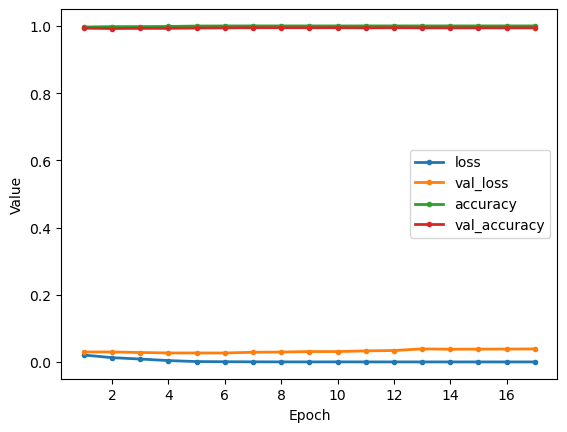

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/87 ━━━━━━━━━━━━━━━━━━━━ 17s 203ms/step

 5/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step  

 9/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

13/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

17/87 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

21/87 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

25/87 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

29/87 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

33/87 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

37/87 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

41/87 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

45/87 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

49/87 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

53/87 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

57/87 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

61/87 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

65/87 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

69/87 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

73/87 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

78/87 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

82/87 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

86/87 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


 1/87 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step

 5/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step  

 9/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

13/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

17/87 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

21/87 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

25/87 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

29/87 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

33/87 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

37/87 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

41/87 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

46/87 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

50/87 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

54/87 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

58/87 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

62/87 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

66/87 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

70/87 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

74/87 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

78/87 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

83/87 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [26]:
report.save()

Report saved as Output/Reports/MIKC_MADS/report_F2BM5RDQ.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################